# Piogge in Australia
In questo notebook si tenta di realizzare un modello univariato per predire la quantità di pioggia il giorno dopo. 

I dati sono acquisiti da Kaggle ([Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)). Contengo circa 10 anni di osservazioni giornaliere in diverse località dell'Australia.

Si inizia con l'analisi dei dati per eseguire un'accurata pulizia dei dati. Dopo di che si passa alla costruzione di un modello ARIMA per le predizioni.

## Preparazione dell'ambiente di sviluppo

In [ ]:
%%capture
!pip install geopandas
!pip install seaborn
!pip install sklearn
!pip install --upgrade --no-deps statsmodels # altrimenti installa una versione vecchia

In [ ]:
!pip show geopandas
print("\n")
!pip show seaborn
print("\n")
!pip show sklearn
print("\n")
!pip show statsmodels
print("\n")
!pip show tensorflow

Name: geopandas
Version: 0.10.2
Summary: Geographic pandas extensions
Home-page: http://geopandas.org
Author: GeoPandas contributors
Author-email: kjordahl@alum.mit.edu
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: shapely, pyproj, fiona, pandas
Required-by: 


Name: seaborn
Version: 0.11.2
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@gmail.com
License: BSD (3-clause)
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, matplotlib, pandas
Required-by: missingno


Name: sklearn
Version: 0.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://pypi.python.org/pypi/scikit-learn/
Author: UNKNOWN
Author-email: UNKNOWN
License: None
Location: /usr/local/lib/python3.7/dist-packages
Requires: scikit-learn
Required-by: 


Name: statsmodels
Version: 0.13.2
Summary: Statistical computations and models for Python
Home-page: https:/

In [ ]:
!git clone https://github.com/Renato89/rain-in-australia.git

fatal: destination path 'rain-in-australia' already exists and is not an empty directory.


In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import math
import missingno
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import re
import geopandas
import folium
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import difflib
from sklearn.impute import KNNImputer

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from pandas.plotting import lag_plot
from matplotlib import pyplot
from pandas import concat
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from keras import layers

from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from numpy import concatenate

import datetime

import IPython
import IPython.display
import matplotlib as mpl

import tensorflow as tf

## Il dataset

In [ ]:
df = pd.read_csv('rain-in-australia/data/weatherAUS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


Un' oservazione al giorno per un periodo di quasi dieci anni, raggruppati per località. 

Procediamo con il recupero delle informazioni geografiche per ognuna delle località e le visualizza su una mappa.
La libreria usata si chiama geopandas e si basa sui *DataFrame* di *pandas* ma con l'aggiunta di un campo che contiene informazioni geometriche del record.
Inoltre, si sfrutta la libreria *folium* per visualizzare le località su una mappa interattiva. 

Per ottenere la mappa bisogna, però, prima recuperare le coordinate di ogni località. *geopandas* aiuta anche in questo con la funzione `geocode(<nome località>)`.


In [ ]:
app = Nominatim(user_agent="renato")

lat = []
lon = []
loc = []
not_found = [] 
for loc_name in df['Location'].unique():
    formatted = re.sub("([a-z])([A-Z])","\g<1> \g<2>", loc_name)
    display_name = formatted + ', Australia'
    location = app.geocode(display_name)
    if location != None:
        lat.append(location.raw['lat'])
        lon.append(location.raw['lon'])
        loc.append(loc_name)
    else:
        not_found.append(loc_name)

d = {'Location':loc, 'Latitude':lat, 'Longitude':lon}
geolocations = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(
    geolocations, 
    geometry=geopandas.points_from_xy(geolocations.Longitude, geolocations.Latitude))

print("Località non trovate: ", len(not_found))

Località non trovate:  0


In [ ]:
m = folium.Map(location=[-23, 133], zoom_start=4.4, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    lat = r['geometry'].y
    lon = r['geometry'].x
    folium.Marker(location=[lat, lon],
                  popup='{} <br> lat: {} <br> lon: {}'.format(r['Location'], lat, lon)).add_to(m)

m

#Pulizia dei dati

Il primo problema da affrontare è conoscere la quantità dei dati mancanti. Per avere un'idea chiara si possono sfruttare strumenti di visualizzazione come ciò che mette a disposizione la libreria missingno. Questa mostra in una matrice grafica la distribuzione dei valori nulli di tutte le colonne. 

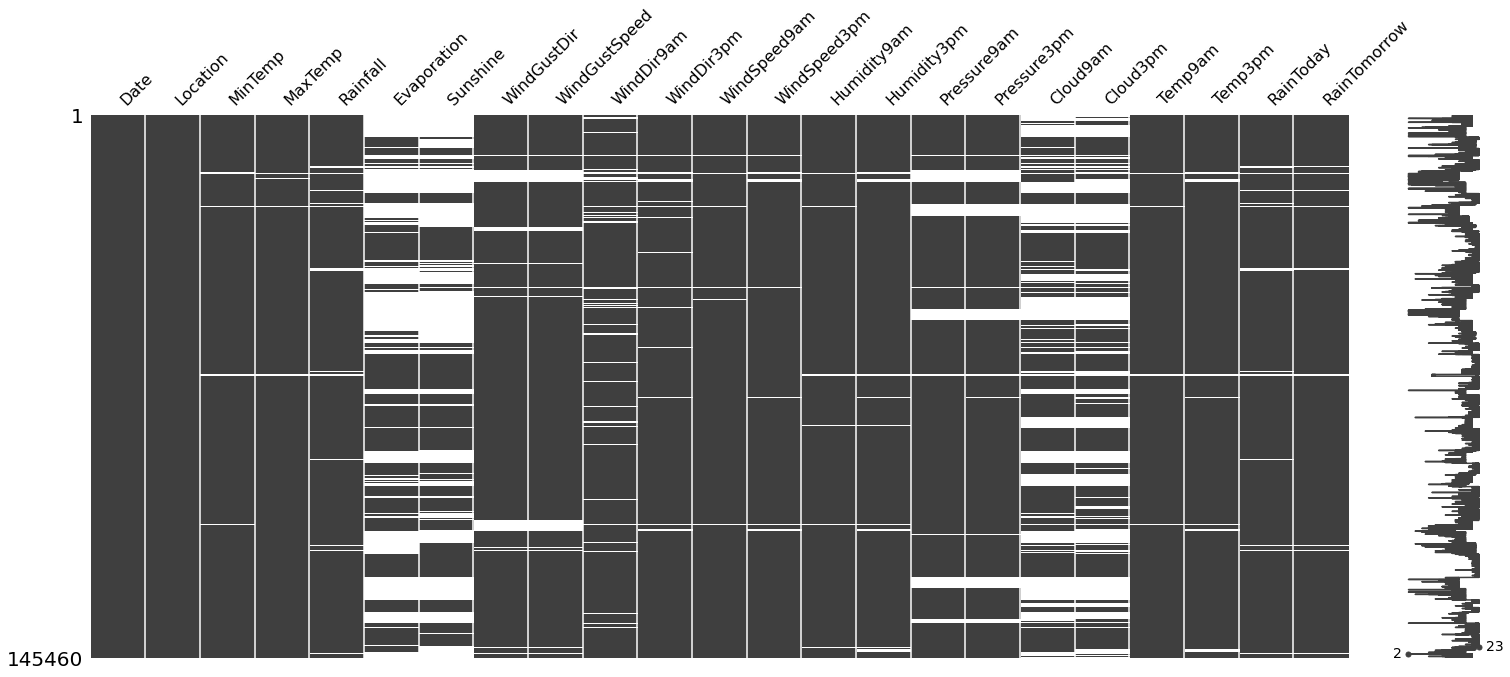

In [ ]:
#@title
if df.isnull().any(axis=None):
    missingno.matrix(df)

Le linee orizantali bianche indicano la presenza di valori nulli. All'estremità destra si ha un riscontro grafico sulla densità di tali valori mancanti.

Per avere un'idea di massima di dove iniziare a correggere il problema, si può visualizzare l'istogramma che mostra il conteggio delle osservazioni per ogni giorno.

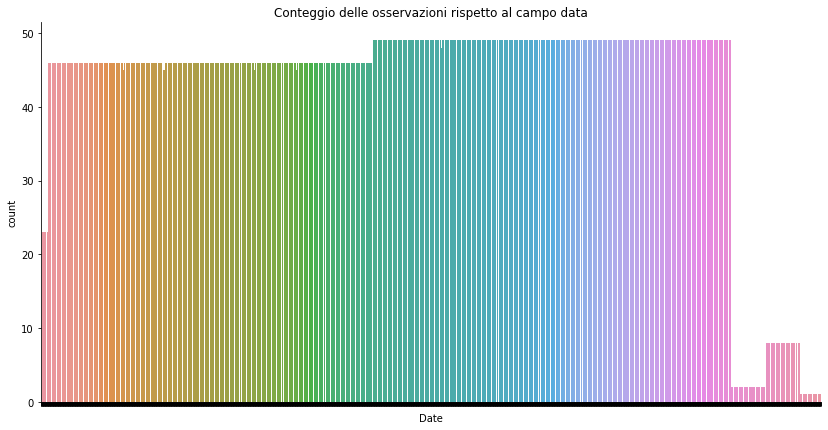

In [ ]:
fig = sns.catplot(x='Date', kind='count', data=df, height=6, aspect=2)
fig.set(xticklabels=[], title='Conteggio delle osservazioni rispetto al campo data')

Il grafico mostra il conteggio delle osservazioni per ogni campo data della tabella. Infatti, per lo stesso giorno, abbiamo l'osservazioni di diverse stazioni meteorologiche dislocate in 49 città.
Si nota dal grafico come un porzione iniziale ed una buona fetta nella parte finale del periodo di osservazione, soffrano di mancanza dati. Inoltre, si può vedere che circa la metà della serie abbia una porzione piccola di località che possiede poche osservazioni. Si interviene su questi due aspetti per "ritagliarsi" un porzione contiugua della serie che possieda una bassa percentuale di valori nulli.



## Rimozione di record non validi
Da queste informazioni, possiamo scegliere di individuare ed escludere quelle località e quei periodi dal dataset in modo da avere un notevole miglioramento nella qualità dei dati.

Iniziamo col tagliare via le date all'inizio ed alla fine del periodo di osservazione che possiedono pochissime osservazioni. Si può vedere che queste hanno un conteggio inferiore a 30. Trovandosi all'estremità del periodo, non inficierà sul modello della serie.

In [ ]:
valid_records = df['Date'].value_counts() > 30
filter = [ valid_records[x]  for x in df['Date']]

truncated_df = df[filter]

print("Numero di osservazioni rimosse: ", len(df) - len(truncated_df))

Numero di osservazioni rimosse:  2331


A questo punto cerchiamo le località che hanno mancanza di dati.

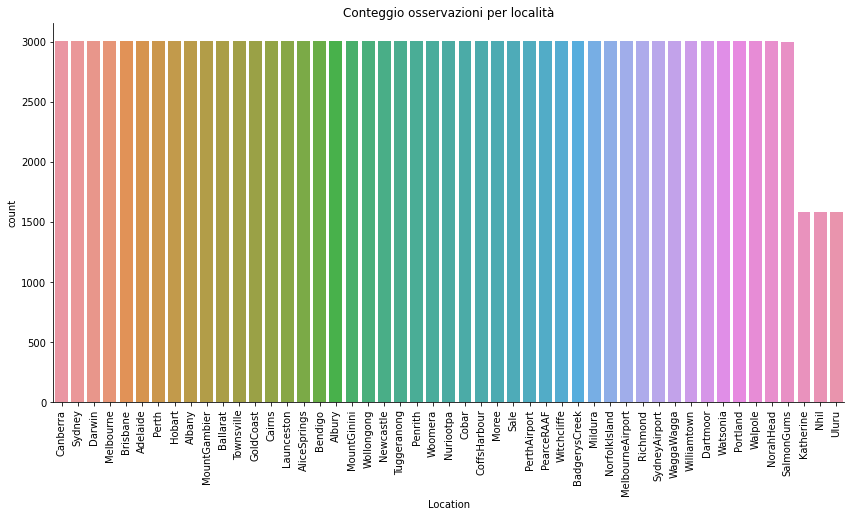

In [ ]:
fig = sns.catplot(x='Location', kind='count', data=truncated_df, height=6, aspect=2, order=df['Location'].value_counts().index)
fig.set_xticklabels(rotation=90)
fig.set(title='Conteggio osservazioni per località')

Tre località possiedo metà dei dati rispetto alle altre 46. Queste sono: Katherine, Nhil e Uluru. Decidiamo di eliminarle. Eliminandole, le escludiamo dal modello predittivo, possiamo farlo perchè abbiamo a disposizione una serie temporale per ogni località, quindi, ne abbiamo a disposizione ancora 46.


In [ ]:
filtered_df = truncated_df[(truncated_df['Location'] != 'Katherine' ) & 
                           (truncated_df['Location'] != 'Nhil' ) & 
                           (truncated_df['Location'] != 'Uluru' )]
print("Numero di osservazioni rimosse: ", len(truncated_df) - len(filtered_df))

Numero di osservazioni rimosse:  4734


Verifichiamo se il "ritaglio" è andato a buon fine.

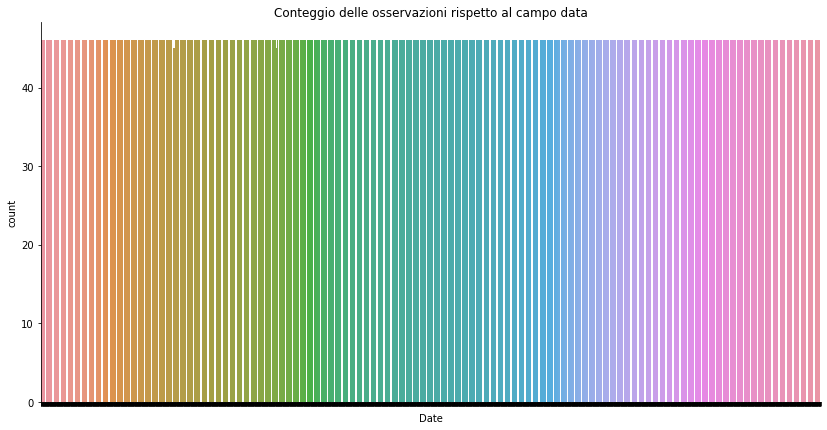

In [ ]:
fig = sns.catplot(x='Date', kind='count', data=filtered_df, height=6, aspect=2)
fig.set(xticklabels=[], title='Conteggio delle osservazioni rispetto al campo data')

## Imputazione
A questo punto bisogna occuparsi di attribuire un valore ai campi nulli rimasti.
Avendo a disposizione molte località da cui sono state prese le misure, se una località possiede un valore nullo, con buona probabilità il valore catturato da una stazione vicina non è nullo e vicino a quello che sarebbe stato il valore reale.
Quindi, si riordina la serie per data, in modo tale da avere vicini le osservazioni dello stesso giorno, e poi si esegue un'imputazione semplice, assegnando il valore più vicino valido quando si incontra un dato mancante.

In [ ]:
def compareNullValues(before_df, after_df):
    before = (before_df.isnull().mean()*100).rename('Prima')
    after = (after_df.isnull().mean()*100).rename('Dopo')

    null_count = before.to_frame().merge(after.rename('Dopo'), left_index=True, right_index=True)
    print("Percentuali di valori non validi:\n")
    print(null_count)

In [ ]:
def imputeByNeighbour(df):

    result = pd.DataFrame()

    grouped_by_day = df.groupby("Date");

    # Per ogni gruppo (giorno)  
    
    for day, group in grouped_by_day:

        valid_values = {}
        for col_label in group: # e per ogni colonna,
            
            # prendo il primo valore non null che trovo

            valid_values[col_label] = next(
                (el for el in group[col_label] if not pd.isnull(el)), None)

        
        # sostituisco tale valore ad ogni null che trovo

        for col_label in group:
            group[col_label].fillna(valid_values[col_label], inplace = True)
        
        # Ricostruisco il dataframe gruppo per gruppo

        result = result.append(group)  # operazione non inplace, perciò si riassegna il risultato
    
    return result

In [ ]:
imputed_df = imputeByNeighbour(filtered_df) # ... ci mette quasi un minuto

In [ ]:
compareNullValues(filtered_df, imputed_df)

Percentuali di valori non validi:

                   Prima  Dopo
Date            0.000000   0.0
Location        0.000000   0.0
MinTemp         1.000759   0.0
MaxTemp         0.867083   0.0
Rainfall        2.278261   0.0
Evaporation    42.777557   0.0
Sunshine       46.806604   0.0
WindGustDir     7.066007   0.0
WindGustSpeed   7.021207   0.0
WindDir9am      7.455472   0.0
WindDir3pm      2.997941   0.0
WindSpeed9am    1.224755   0.0
WindSpeed3pm    2.169154   0.0
Humidity9am     1.826656   0.0
Humidity3pm     2.629430   0.0
Pressure9am    10.805304   0.0
Pressure3pm    10.780736   0.0
Cloud9am       38.050508   0.0
Cloud3pm       40.106940   0.0
Temp9am         1.218252   0.0
Temp3pm         2.066549   0.0
RainToday       2.278261   0.0
RainTomorrow    2.281874   0.0


## Date mancanti
Nonostante i valori nulli non siano più presenti può sempre essere presente il problema di date mancanti. Per effettuare le predizioni è necessario che ogni riga rappresenti lo stesso intervallo di tempo, nel nostro caso un giorno. Quindi, si esegue la seguente procedura:


1.   si individua l'intervallo temporale della serie
2.   si genera una lista di indici temporali con frequenza giornaliera
3.   la si confronta con quella del dataset e, se non corrisponde, significano che mancano dei giorni, e quindi,
4.   si espande la serie temporale con le dati mancanti aggiungendo dei valori 
nulli
5.   si estraggono gli stessi periodi mancanti ma dell'anno precedente e,
6.   si sostituiscono con essi.


In [ ]:
extracted_days = pd.to_datetime(imputed_df['Date'].unique())

print("Finestra temporale da '", extracted_days.min(), "' a '", extracted_days.max(), "'") 

Finestra temporale da ' 2009-01-01 00:00:00 ' a ' 2017-06-25 00:00:00 '


In [ ]:
complete_period = pd.period_range(
    extracted_days.min(), extracted_days.max(), freq = 'D')

print("Numero di giorni del periodo: ", len(complete_period))
print("Numero di record nei dati: ", len(extracted_days))
print("Mancano: ", len(complete_period) - len(extracted_days), " record")

Numero di giorni del periodo:  3098
Numero di record nei dati:  3009
Mancano:  89  record


Quali date mancano? *pandas* mette a disposizione delle classi per gestire le date, come fare operazioni

In [ ]:
def findMissingPeriods(df):
    
    result = []

    extracted_days = pd.to_datetime(df['Date'].unique())

    complete_period = pd.period_range(
        extracted_days.min(), extracted_days.max(), freq = 'D')
    
    counter = 0
    for day in complete_period.to_timestamp() :

        if day not in extracted_days:
            counter += 1
        elif counter > 0:
            start = day - pd.Timedelta(counter, unit='D')   
            end = day - pd.Timedelta(1, unit='D')

            result.append(pd.period_range(start, end, freq = 'D'))
            counter = 0


    return result

In [ ]:
print("Periodi mancant:\n")
for period in findMissingPeriods(imputed_df):
    print(period)

Periodi mancant:

PeriodIndex(['2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04',
             '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-08',
             '2011-04-09', '2011-04-10', '2011-04-11', '2011-04-12',
             '2011-04-13', '2011-04-14', '2011-04-15', '2011-04-16',
             '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20',
             '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24',
             '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28',
             '2011-04-29', '2011-04-30'],
            dtype='period[D]')
PeriodIndex(['2012-12-01', '2012-12-02', '2012-12-03', '2012-12-04',
             '2012-12-05', '2012-12-06', '2012-12-07', '2012-12-08',
             '2012-12-09', '2012-12-10', '2012-12-11', '2012-12-12',
             '2012-12-13', '2012-12-14', '2012-12-15', '2012-12-16',
             '2012-12-17', '2012-12-18', '2012-12-19', '2012-12-20',
             '2012-12-21', '2012-12-22', '2012-12-23', '2012-12-24',
            

In [ ]:
def expandWithMissingDates(df, location_col, date_col):
    
    result = pd.DataFrame()
    
    # Per ogni località
    for location, group in df.groupby(location_col):

        extracted_days = pd.to_datetime(imputed_df[date_col].unique())    

        complete_period = pd.period_range(
            extracted_days.min(), extracted_days.max(), freq = 'D')

        # Usa la colonna Date come indice

        group.index = pd.to_datetime(group[date_col])

        # Reindicizza

        expanded = group.reindex(complete_period.to_timestamp())

        expanded[location_col] = location
        expanded[date_col] = expanded.index

        result = result.append(expanded)

    return result
    

In [ ]:
expanded_df = expandWithMissingDates(imputed_df, "Location", "Date")

In [ ]:
def imputeByPreviousYear(df, location_col, date_col):

    result = pd.DataFrame()

    missing_periods = findMissingPeriods(df)

    # Per ogni località

    for location, group in df.groupby(location_col):

        expanded = expandWithMissingDates(group, location_col, date_col)

        # Riempi i vuoti con lo stesso periodo dell'anno precedente

        for period in missing_periods:

            prev_year = period - pd.Timedelta(365, unit='D')
            expanded.loc[period.to_timestamp()] = expanded.loc[prev_year.to_timestamp()].values

        
        result = result.append(expanded)
    
    return result

In [ ]:
clean_df = imputeByPreviousYear(imputed_df,  "Location", "Date")

In [ ]:
compareNullValues(expanded_df, clean_df)

Percentuali di valori non validi:

                  Prima      Dopo
Date           0.000000  0.000000
Location       0.000000  0.000000
MinTemp        2.886154  0.013333
MaxTemp        2.886154  0.013333
Rainfall       2.886154  0.013333
Evaporation    2.886154  0.013333
Sunshine       2.886154  0.013333
WindGustDir    2.886154  0.013333
WindGustSpeed  2.886154  0.013333
WindDir9am     2.886154  0.013333
WindDir3pm     2.886154  0.013333
WindSpeed9am   2.886154  0.013333
WindSpeed3pm   2.886154  0.013333
Humidity9am    2.886154  0.013333
Humidity3pm    2.886154  0.013333
Pressure9am    2.886154  0.013333
Pressure3pm    2.886154  0.013333
Cloud9am       2.886154  0.013333
Cloud3pm       2.886154  0.013333
Temp9am        2.886154  0.013333
Temp3pm        2.886154  0.013333
RainToday      2.886154  0.013333
RainTomorrow   2.886154  0.013333


In [ ]:
clean_df[clean_df['MinTemp'].isnull()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2017-06-25,2017-06-25,Newcastle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-27,2013-12-27,NorahHead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-28,2013-12-28,NorahHead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-29,2013-12-29,NorahHead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-30,2013-12-30,NorahHead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,2013-12-31,NorahHead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-11-30,2009-11-30,Penrith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-24,2010-05-24,SalmonGums,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-25,2010-05-25,SalmonGums,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-26,2010-05-26,SalmonGums,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mancano ancora dei valori. Queste date sono presenti in altre località ma non in tutte. Qunidi, si ripete l'imputazione per vicinanza.

In [ ]:
full_df = imputeByNeighbour(clean_df)

In [ ]:
compareNullValues(clean_df, full_df)

Percentuali di valori non validi:

                  Prima  Dopo
Date           0.000000   0.0
Location       0.000000   0.0
MinTemp        0.013333   0.0
MaxTemp        0.013333   0.0
Rainfall       0.013333   0.0
Evaporation    0.013333   0.0
Sunshine       0.013333   0.0
WindGustDir    0.013333   0.0
WindGustSpeed  0.013333   0.0
WindDir9am     0.013333   0.0
WindDir3pm     0.013333   0.0
WindSpeed9am   0.013333   0.0
WindSpeed3pm   0.013333   0.0
Humidity9am    0.013333   0.0
Humidity3pm    0.013333   0.0
Pressure9am    0.013333   0.0
Pressure3pm    0.013333   0.0
Cloud9am       0.013333   0.0
Cloud3pm       0.013333   0.0
Temp9am        0.013333   0.0
Temp3pm        0.013333   0.0
RainToday      0.013333   0.0
RainTomorrow   0.013333   0.0


Adesso si possiede un dataset con tutte le date e campi mancanti imputati con valori verosimili.

# Analisi descrittiva
Nelle seguenti righe, vengono forniti informazioni descrittive del dataset come, per esempio, la stazionarietà delle singole serie (singole colonne), oppure la correlazione e l'autocorrelazione.
Si inizia con lo studio della correlazione per aiutarci ad individuare un insieme di dati più utili di altri nella costruzione dei modelli che verranno successivamente implementati. Lo scopo di questi modelli, infatti, sarà quello di prevedere le piogge il giorno successivo alla lettura di uno o più valori meteorologici. La nostra variabile "target" , quindi, è "RainTomorrow".


##Correlazione con le piogge del giorno dopo

Per la correlazione si calcola il coefficiente di correlazione per ogni coppia di colonna ed i risultati vengono visualizzati sfruttando la funzionalità di Seaborn "heatmap" che mostra i dati sotto forma di matrice termica.

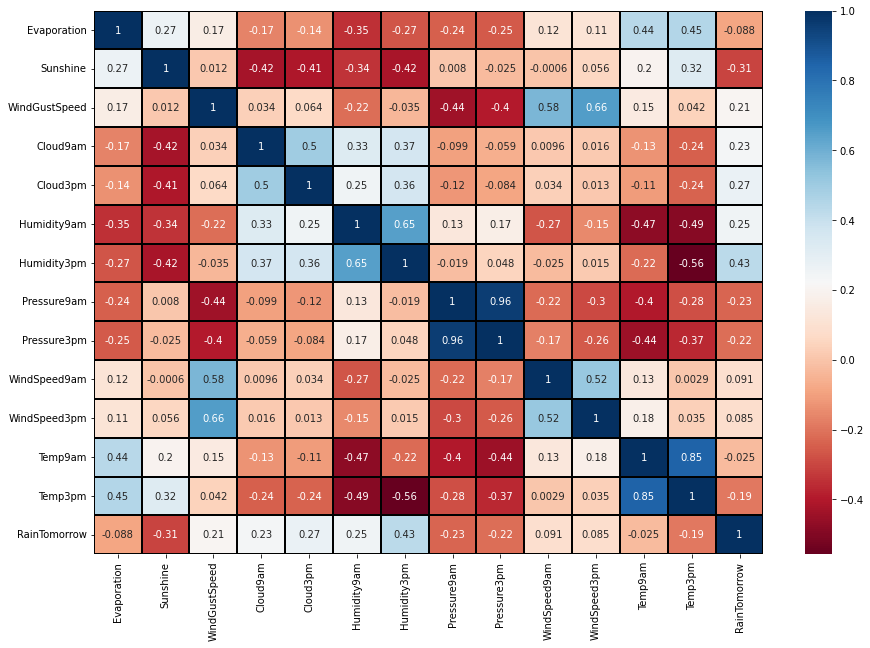

In [ ]:
# Tolgo un warning di default di pandas per poter sovrascrivere le colonne del Dataframe
pd.options.mode.chained_assignment = None  # default='warn'

columns = full_df[['Evaporation', 'Sunshine', 'WindGustSpeed', 'Cloud9am','Cloud3pm', 
                   'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm','WindSpeed9am',
                   'WindSpeed3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']]

# Metto la sentenza 'No' su tutta la colonna di RainTomorrow
columns['RainTomorrow'] = columns['RainTomorrow'].fillna('No')

# Faccio lo scaling nella colonna di RainTomorrow (Saranno tutti 0)
le = LabelEncoder()
columns['RainTomorrow'] = le.fit_transform(columns['RainTomorrow'])

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(columns.corr(), cmap = 'RdBu', annot = True, linewidths=1, linecolor='black')

Uso la funzione corr() per calcolare l'indice di correlazione fra le variabili.

La mappa ci informa delle seguenti correlazioni con "RainTomorrow":

*   Cloud9am e Cloud3pm sono correlate positivamente con RainTomorrow.
*   Con Evaporation la correlazione è molto bassa.
*   Con Sunshine c'è una correlazione negativa.
*   La maggiore correlazione la si ottiene con l'umidità pomeriadana del giorno prima e la quantità di sole.

Per quando riguarda la correlazioni tra le variabili diverse da "RainTomorrow", otteniamo che:
*   Una bassa pressione coincide, come ci si aspettava, a forti venti.
*   La quantità di sole è collegata molto a tutte le altre tranne per la pressione.
*   L'umidità influenza molto la temperatura.




## Quantità di piogge per ogni mese
Vogliamovedere, adesso, la quantità di piogge per avere un'idea della loro distribuzione nell'arco dell'anno. L'informazione può essere utile per individuare un periodo più soggetto alle piogge e quindi con più alto contenuto informativo nel dataset al periodo corrispondente.

Si tenta di mostrare la stessa informazione usufruendo della libreria *Seaborn*. La procedura seguita è la seguente:


*   Si raggruppa per giorno e si esegue la media della colonna "Rainfall" tra tuttte le località.
*   Si raggruppa per anno e mese e si conta il totale.
*   Si riordina per mese per un' agevole visione.

Allo scopo si fa uso dei grafici *barplot*, *poinplot* e *violinplot*. Sono tutti tipi usati con variabili categoriche che, nel nostro caso, corrispondono ai mesi dell'anno. Questi strumenti, evidenziano diversi aspetti della stessa informazione: il *barplot* fornisce una stima della quantità totale nel mese; il *pointplot* aiuta ad identificare dei trend mentre, *violinplot* motra anche la distribuzione.

In [ ]:
media_tra_localita = full_df.groupby(full_df.index)['Rainfall'].mean().to_frame()

rainfall = media_tra_localita.groupby([media_tra_localita.index.year,
                                             media_tra_localita.index.month,
                                             media_tra_localita.index.month_name()])['Rainfall'].sum()
rainfall = rainfall.to_frame()
rainfall.reset_index(inplace=True)
rainfall.rename(columns = { 'level_0': 'Year', 'level_1': 'Month', 'level_2': 'MonthName'}, inplace=True)
rainfall.sort_values(by=['Year','Month'], inplace=True)

In [ ]:
rainfall

,Year,Month,MonthName,Rainfall
0,2009,1,January,64.323913
1,2009,2,February,106.343478
2,2009,3,March,42.706522
3,2009,4,April,80.321739
4,2009,5,May,62.332609
...,...,...,...,...
97,2017,2,February,77.804348
98,2017,3,March,126.660870
99,2017,4,April,60.004348
100,2017,5,May,48.750000


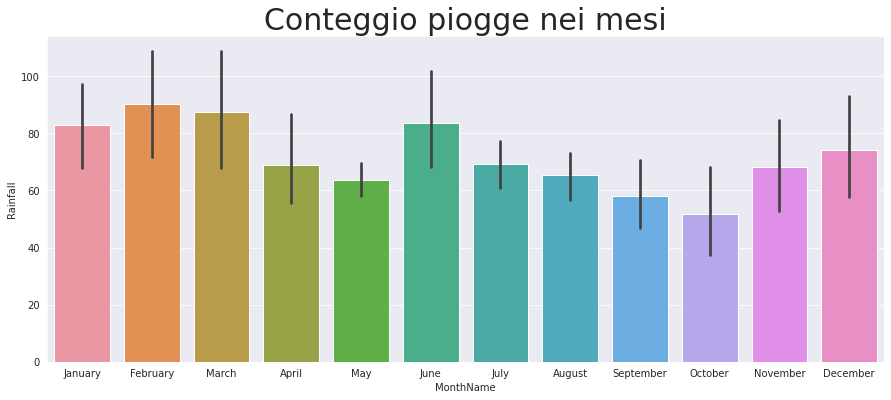

In [ ]:
sns.set_style('darkgrid')

plt.figure(figsize=[15,6])

ax = sns.barplot(x = 'MonthName', y='Rainfall',  data =  rainfall)
ax.set_title( "Conteggio piogge nei mesi", size = 30 )
plt.show()

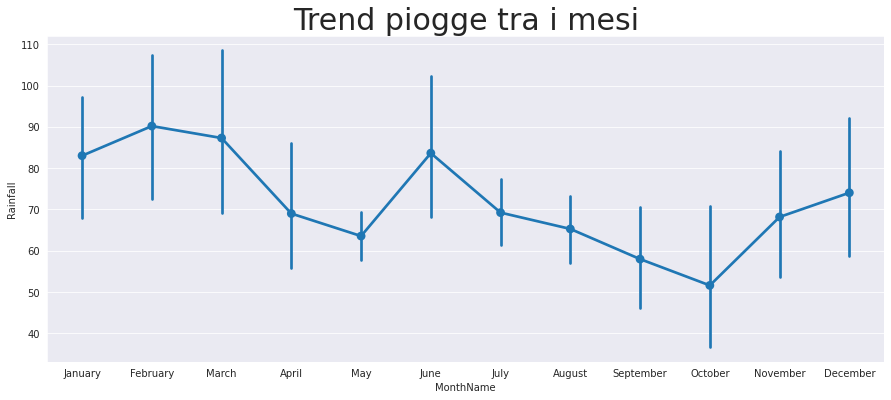

In [ ]:
plt.figure(figsize=[15,6])
ax = sns.pointplot(x = 'MonthName', y = 'Rainfall', data = rainfall )
ax.set_title( "Trend piogge tra i mesi", size = 30 )
plt.show()

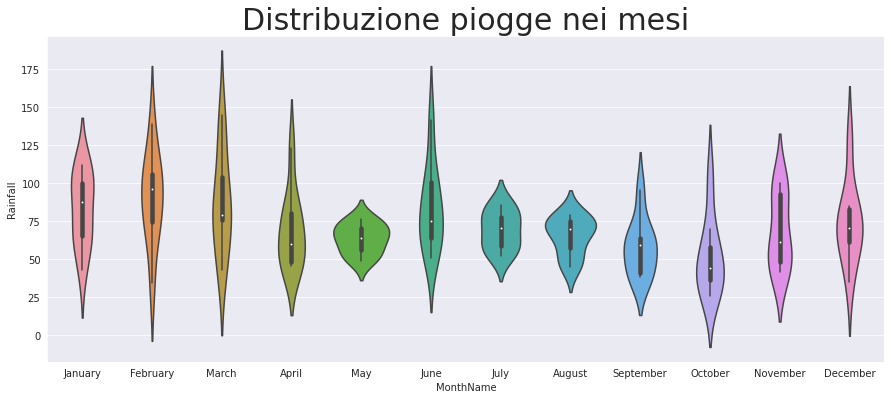

In [ ]:
plt.figure(figsize=[15,6])
ax = sns.violinplot(x = 'MonthName', y = 'Rainfall', data = rainfall )
ax.set_title( "Distribuzione piogge nei mesi", size = 30 )
plt.show()

Possiamo vedere che le piogge sono più dense nei mesi centrali, ovvero maggio, luglio e agosto (sono i mesi invernali in Australia).
In termini di intensità la pioggia è però più intensa nei mesi di Gennaio e Febbraio.
Sembra che comunque, a differenza di altri paesi, in Australia la pioggia è molto frequente in tutto l'anno

## Variazione sul singolo giorno

Andiamo ad analizzare se il cambiamento in giornata (fra mattina e pomeriggio) di alcune variabili metereologiche influenzi la possibilità di pioggia il giorno successivo. Infatti, dati come la velocità del vento e la temperatura sono descritti da due colonne che registrano il valore alle 9 di mattina (9am) ed uno alle 3 del pomeriggio (3pm).

In [ ]:
df_9am = pd.DataFrame()
df_3pm = pd.DataFrame()

for col_name in full_df.columns:
    
    if full_df[col_name].dtype != object:
        
        if str.__contains__(col_name, '9am'):
            df_9am.insert(0, col_name[0: -3], full_df[col_name])

        if str.__contains__(col_name, '3pm'):
            df_3pm.insert(0, col_name[0: -3], full_df[col_name])

In [ ]:
daily_diff_df = df_3pm - df_9am
daily_diff_df.insert(0,"RainTomorrow",full_df["RainTomorrow"])
daily_diff_df

,RainTomorrow,Temp,Cloud,Pressure,Humidity,WindSpeed
2009-01-01,No,4.4,3.0,1.1,-18.0,3.0
2009-01-01,No,1.4,-7.0,-2.3,0.0,18.0
2009-01-01,No,6.0,3.0,-1.3,-20.0,12.0
2009-01-01,No,6.0,-1.0,-2.9,-6.0,6.0
2009-01-01,No,4.7,3.0,-2.4,-41.0,20.0
...,...,...,...,...,...,...
2017-06-25,No,2.7,0.0,-2.3,1.0,2.0
2017-06-25,No,7.0,4.0,-3.5,-28.0,7.0
2017-06-25,No,4.2,1.0,-2.0,-27.0,13.0
2017-06-25,No,5.8,1.0,-2.2,-16.0,16.0


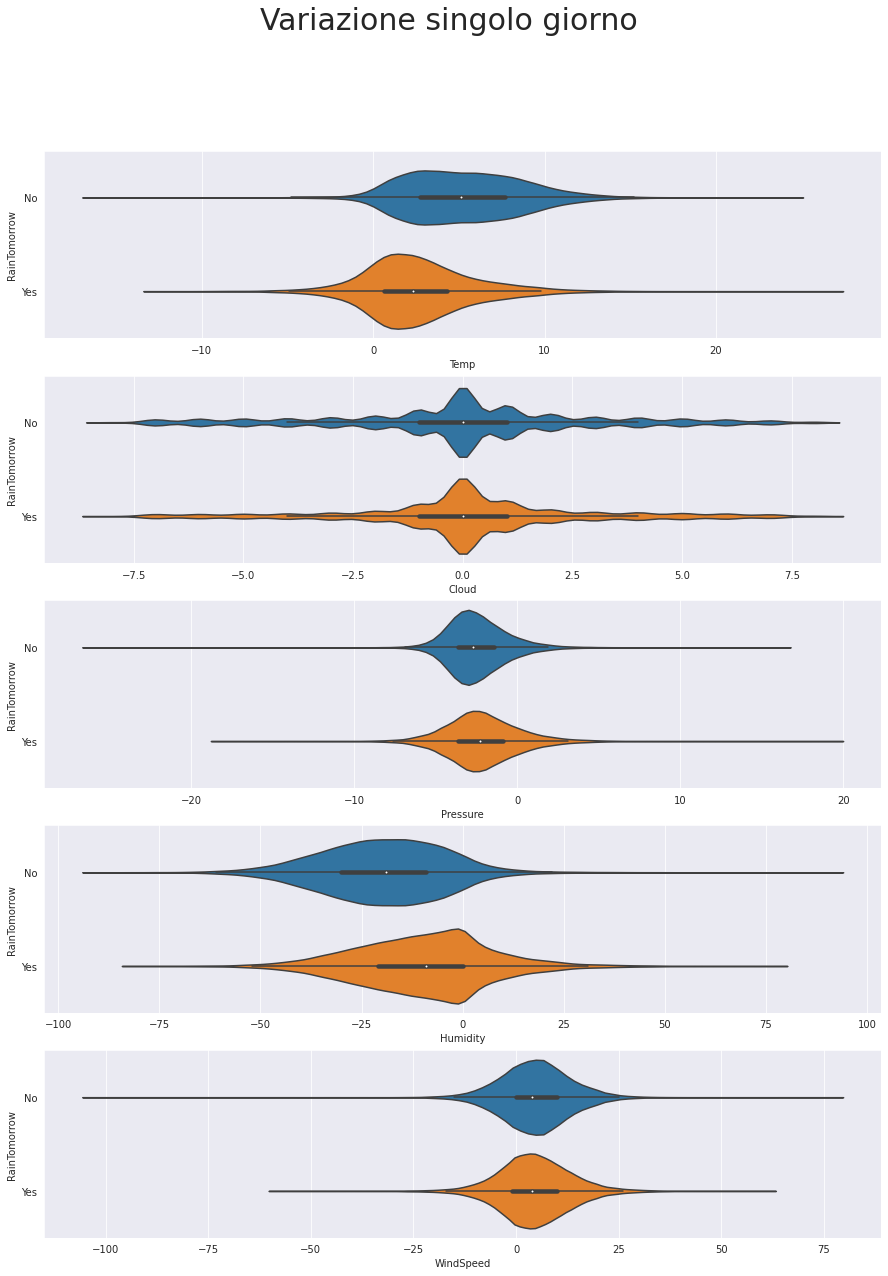

In [ ]:
fig, axes = plt.subplots(5, figsize=[15,20])
fig.suptitle('Variazione singolo giorno', size=30)
sns.violinplot(y="RainTomorrow", x="Temp", data = daily_diff_df, ax=axes[0])
sns.violinplot(y="RainTomorrow", x="Cloud", data = daily_diff_df, ax=axes[1])
sns.violinplot(y="RainTomorrow", x="Pressure", data = daily_diff_df, ax=axes[2])
sns.violinplot(y="RainTomorrow", x="Humidity", data = daily_diff_df, ax=axes[3])
sns.violinplot(y="RainTomorrow", x="WindSpeed", data = daily_diff_df, ax=axes[4])

Sembra che solo con una variazione di temperatura notevole (maggiore di 18 gradi) possiamo dire
con certezza che il giorno dopo non pioverà.
Tuttavia, pare che la sola variazione di temperatura non è sufficiente per stabilire
con un buon grado di fiducia se il giorno dopo pioverà o meno.

Lo stesso discorso vale per la pressione. Non è un indicatore sufficiente da solo. Però, possiamo dire con fiducia che 
con una variazione molto negativa della pressione, il giorno dopo c'è pioggia.

E' sempre nuvoloso in Australia tanto è che non ci sono differenze di nuvole durante la giornata ?!

Per quanto riguarda l'umidità sembra che tale metrica non sia molto utile

## Autocorrelazioni

Cerchiamo un riscontro visivo dell' **autocorrelazione** nella variabili del dataset.La funzione lag_plot() permette di visualizzare le osservazioni all'istante t-1
con le osservazioni allo step successivo, t+1.
Se gli scatter formano una diagonale allora la variabile ha un buon grado di autocorrelazione.

Inoltre viene calcolato l'**indice di correlazione di Pearson** per avere una metrica oggettiva circa il valore di autocorrelazione. I valori vanno da -1 (alta correlazione negativa) a 1 (alta correlazione positiva). 


In [ ]:
# Solo colonne numeriche, della località Sydney

import numbers

num_df = pd.DataFrame()
loc = 'Sydney'
loc_df = full_df[full_df['Location']=='Sydney'] # per una località

for col_name in loc_df.columns:
    
    if pd.api.types.is_numeric_dtype(full_df[col_name].dtype):
        
        num_df.insert(0, col_name, loc_df[col_name])

#num_df = num_df.groupby(num_df.index).mean() # media tra le località

num_df

,Temp3pm,Temp9am,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,Humidity3pm,Humidity9am,WindSpeed3pm,WindSpeed9am,WindGustSpeed,Sunshine,Evaporation,Rainfall,MaxTemp,MinTemp
2009-01-01,34.3,22.0,6.0,4.0,1000.7,1005.5,22.0,73.0,17.0,11.0,56.0,12.9,9.8,0.0,34.7,18.4
2009-01-02,20.8,20.1,7.0,6.0,1013.8,1012.8,57.0,62.0,33.0,11.0,41.0,5.9,11.0,0.0,22.7,18.8
2009-01-03,21.4,18.8,8.0,8.0,1019.4,1021.6,49.0,58.0,15.0,13.0,26.0,0.5,9.0,0.0,23.0,17.0
2009-01-04,24.1,23.0,1.0,2.0,1015.2,1018.6,58.0,59.0,31.0,13.0,37.0,11.3,5.4,0.0,24.6,18.7
2009-01-05,26.2,23.4,4.0,4.0,1008.9,1013.2,60.0,66.0,13.0,6.0,41.0,12.2,10.0,0.0,27.9,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-21,17.9,10.5,2.0,2.0,1025.3,1025.9,52.0,73.0,20.0,22.0,37.0,7.8,2.0,0.0,19.6,8.6
2017-06-22,18.7,11.0,2.0,2.0,1024.6,1028.5,53.0,78.0,7.0,20.0,30.0,9.2,2.0,0.0,19.2,9.3
2017-06-23,17.3,10.2,6.0,6.0,1015.0,1020.8,56.0,85.0,13.0,15.0,24.0,2.7,2.4,0.0,17.7,9.4
2017-06-24,19.0,12.4,2.0,5.0,1015.1,1017.3,35.0,56.0,19.0,17.0,43.0,9.3,1.4,0.0,19.3,10.1


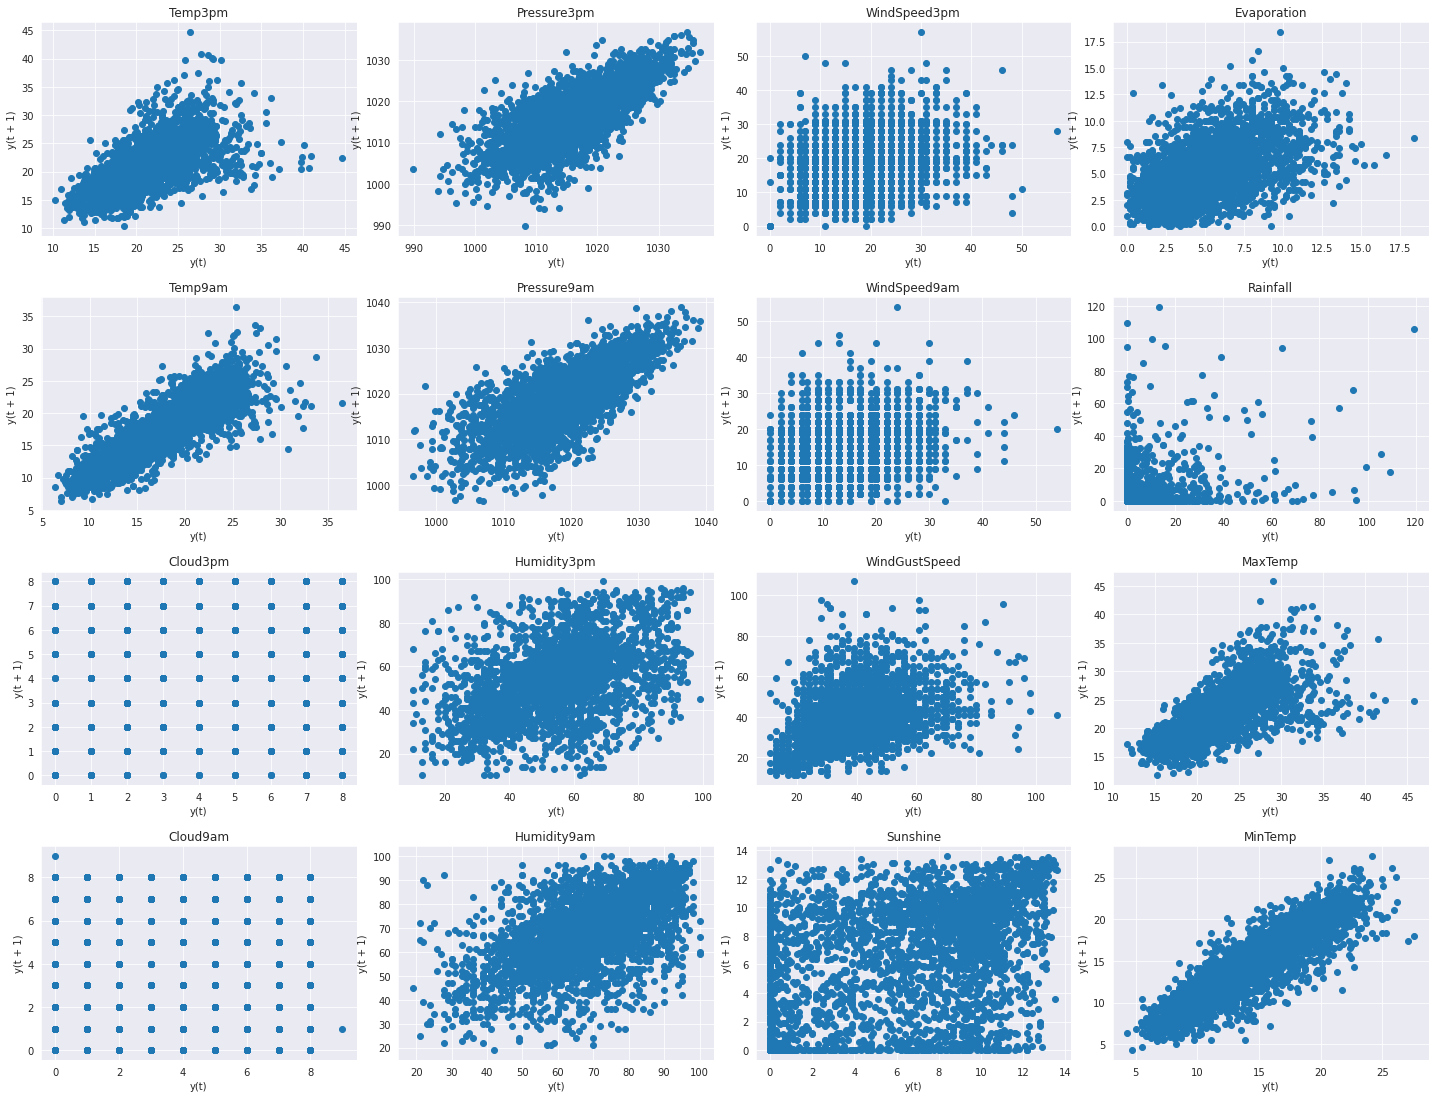

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=[20,15])
fig.tight_layout(h_pad=4)
colors = sns.color_palette("Paired");

num_rows = 4

for j in range(num_rows):

    for i, col_name in enumerate(num_df.columns.values[j::num_rows]): 
        axes[j][i].set_title(col_name)
        pd.plotting.lag_plot(num_df[col_name], ax=axes[j][i], c=[colors[1]]) # Per rimuovere il warning indicare il colore con "c" ed un array 2D

Sembra che non tutte le variabili numeriche del dataset abbiano una buona autocorrelazione.

Però, si notano buone autocorrelazioni per la temperatura e la pressione atmosferica. In aggiunta, siccome sono sono misurazioni prese in due istanti della giornata, si può pensare di accorparle in un unica colonna (9am e 3pm) così da raddoppiare la lunghezza della serie.

Quindi, si procede ad espandere le serie scelte e si calcola l'indice di pearson.

In [ ]:
temp_values = []
press_values = []
indexes = []

for day, row in num_df.iterrows():

    temp_values.append(row['Temp9am'])
    temp_values.append(row['Temp3pm'])
    press_values.append(row['Pressure9am'])
    press_values.append(row['Pressure3pm'])

    idx_am = day + pd.to_timedelta(9, 'h')
    indexes.append(idx_am)
    indexes.append(day + pd.to_timedelta(15, 'h'))

temperature = pd.Series(temp_values, index = indexes)
pressure = pd.Series(press_values, index = indexes)

In [ ]:
temperature.head()

2009-01-01 09:00:00    22.0
2009-01-01 15:00:00    34.3
2009-01-02 09:00:00    20.1
2009-01-02 15:00:00    20.8
2009-01-03 09:00:00    18.8
dtype: float64

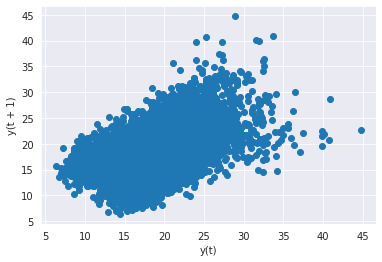



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.535502
t+1  0.535502  1.000000


In [ ]:
# Disegno il grafico
lag_plot(temperature)
pyplot.show()

# Calcolo l'indice di correlazione
values = temperature.to_frame()
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

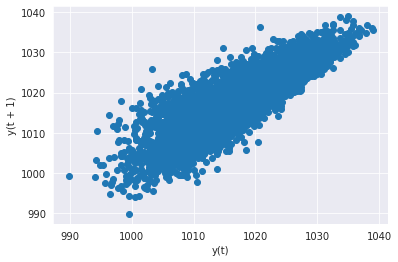



Indice di correlazione di Pearson: 
          t-1       t+1
t-1  1.000000  0.838766
t+1  0.838766  1.000000


In [ ]:
lag_plot(pressure)
pyplot.show()

values = pressure.to_frame()
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print("\n")
print("Indice di correlazione di Pearson: ")
print(result)

La pressione atmosferica sembra mantenere una buona autocorrelazione.
A questo punto, decidiamo di procedere con la costruzione di un modello basato sulle serie temporali estratte dalla colonna della pressione.

# Analisi predittiva
Si sceglie inizialmente il modello ARIMA. Prendiamo una località, per esempio Sydney e verifichiamo la stazionarietà della serie.

## Arima per la previsione delle piogge


### Scelta del parametro di differenziazione


In [ ]:
data = full_df[full_df['Location']=='Sydney']['Rainfall'].to_frame().sort_index()
data['D.Rainfall'] = data['Rainfall'].diff()
data['D2.Rainfall'] = data['Rainfall'].diff().diff()

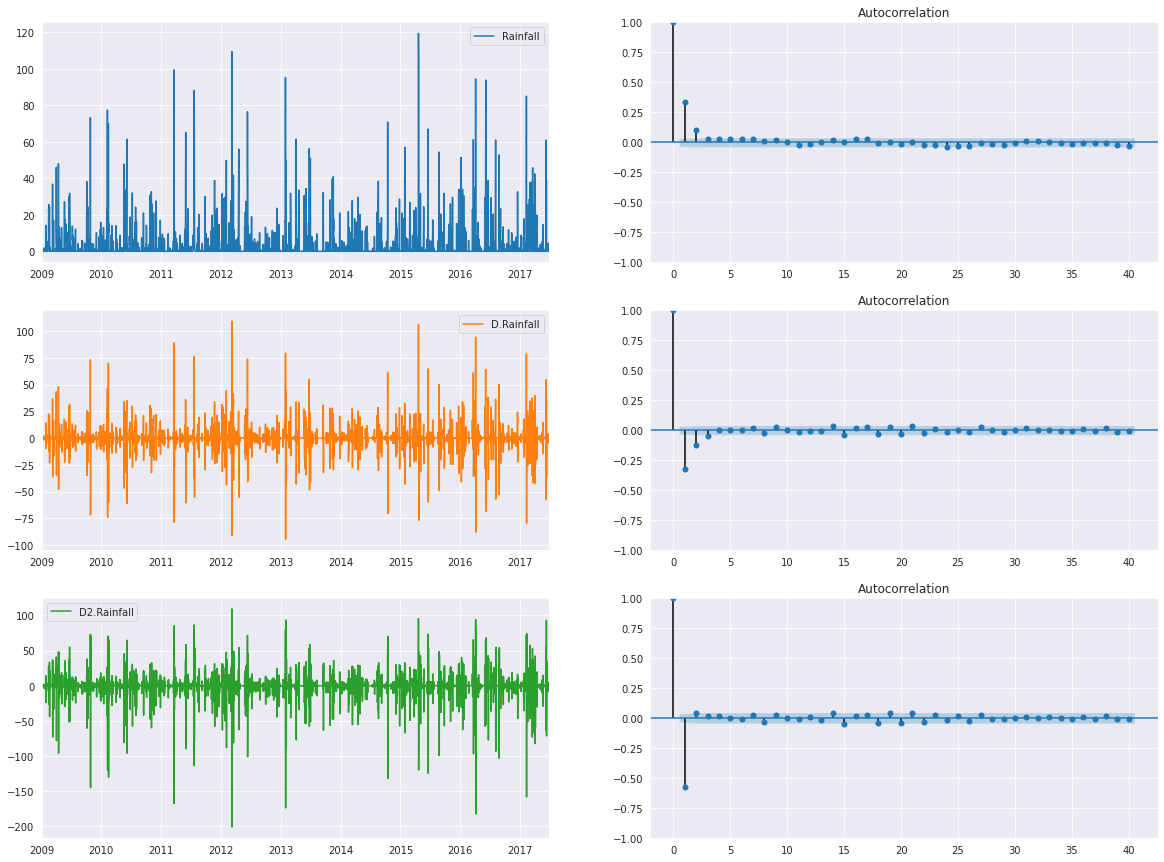

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=[20,15])

data.plot(kind='line',subplots=True, figsize=(15,10), ax=axes[:,0])

sm.graphics.tsa.plot_acf(data['Rainfall'], ax=axes[0,1], lags=40)
sm.graphics.tsa.plot_acf(data['D.Rainfall'].dropna(), ax=axes[1,1], lags=40)
sm.graphics.tsa.plot_acf(data['D2.Rainfall'].dropna(), ax=axes[2,1], lags=40)

plt.show()

Dal grafico di auto-correlazione possiamo decidere se è necessaria più differenziazione. Se molti punti sono consecutivamente positivi, allora è necessario differenziare ulteriormente. Al contrario, se molti punti sono negatvi, la serie è eccessivamente differenziata.

In [ ]:
pv = adfuller(data['Rainfall'][0:10].dropna())
print('p-value: ', pv[1])
pv_d = adfuller(data['D.Rainfall'][0:10].dropna())
print('p-value: ', pv_d[1])
pv_d2 = adfuller(data['D2.Rainfall'][0:10].dropna())
print('p-value: ', pv_d2[1])

p-value:  0.034894400275345266
p-value:  0.00020436368424532058
p-value:  9.818550122504382e-09


Con una differrenziazione di secondo ordine abbiamo un p-value motlo al di sotto del valore di 0.05. Perciò, si prende un parametro "d" da 2 e verifichiamo in seguiito come si comporta.

### Scelta del parametro di media mobile (MA)


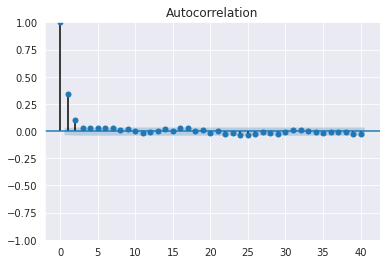

In [ ]:
sm.graphics.tsa.plot_acf(data['Rainfall'].values.squeeze(), lags=40)
plt.show()

Il numero dei primi punti che si trovano al di fuori dell'area di confidenza, indica il numero di termini necessari per rimuovere l'autocorrelazione dalla serie stazionaria. Ossia il numero di istanti di tempo nel passato che influenzano di più la predizione.

In questo caso scegliamo un valore di autoregressione (MA) di 3.

### Scelta del parametro di autoregressione (AR)
Si ispeziona i termini precedenti senza considerari quelli nel mezzo.

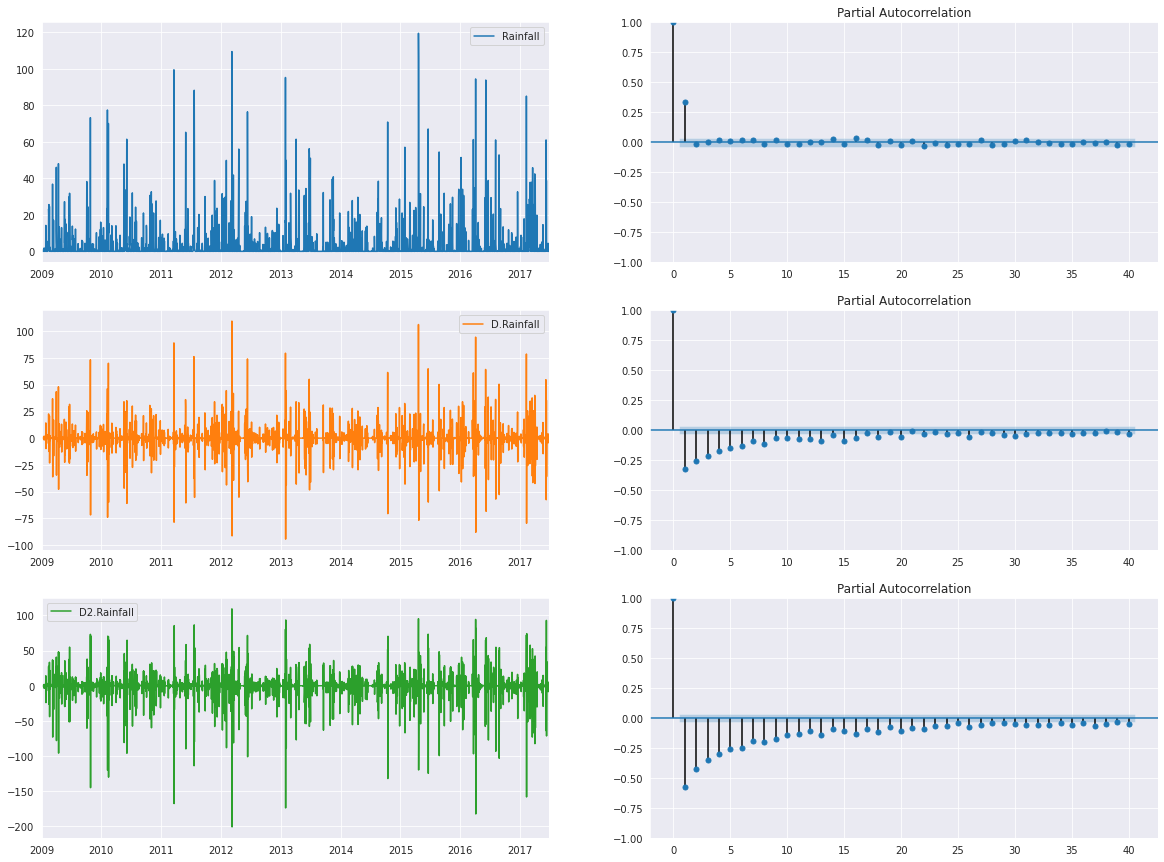

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=[20,15])

data.plot(kind='line',subplots=True, figsize=(15,10), ax=axes[:,0])

sm.graphics.tsa.plot_pacf(data['Rainfall'], ax=axes[0,1], lags=40, method='ywm')
sm.graphics.tsa.plot_pacf(data['D.Rainfall'].dropna(), ax=axes[1,1], lags=40, method='ywm')
sm.graphics.tsa.plot_pacf(data['D2.Rainfall'].dropna(), ax=axes[2,1], lags=40, method='ywm')

plt.show()

Valutando i grafici di autocorrelazione parziale, si vede che il primo istante è il più significativo. Si sceglie il parametro di autoregressione p=1.

Adesso, usiamo la funzione ARIMA() indicando l'ordine (p, d, q) con i parametri che abbiamo trovato.

In [ ]:
rainfall_model = sm.tsa.arima.ARIMA(data['Rainfall'].values, order=(1,3,3)) 
rainfall_results = rainfall_model.fit() 
print(rainfall_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3098
Model:                 ARIMA(1, 3, 3)   Log Likelihood              -11956.840
Date:                Sun, 12 Jun 2022   AIC                          23923.680
Time:                        15:35:26   BIC                          23953.867
Sample:                             0   HQIC                         23934.521
                               - 3098                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9992      0.006   -173.697      0.000      -1.010      -0.988
ma.L1         -1.0007      0.155     -6.470      0.000      -1.304      -0.698
ma.L2         -0.9974      0.013    -76.694      0.0

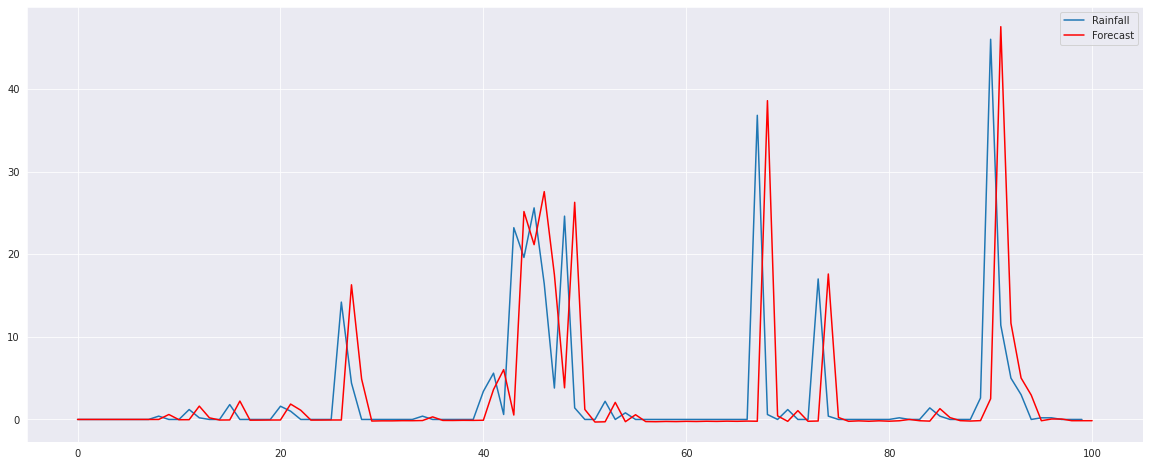

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(data['Rainfall'].values[0:100])
plt.plot(rainfall_results.predict(start=0, end=100), color='red')
ax.legend(['Rainfall', 'Forecast'])

### Considerazioni
Si nota come le previsioni tendano semplicemente a "inseguire" l'andamento reale delle piogge. Si conclude quindi che la serie da sola non ha informazioni utili per ottenere una previsione accurata.

Probabilmente, altri dati come la temperatura e l'umidità, con l'uso di modelli multivariati potrebbero migliorare i risultati.

## Arima sulla pressione atmosferica

Si tenta adesso ad eseguire lo stesso procedimento ma con una delle serie estrapolate in precedenza che possiede un'alta autocorrelazione. In questo caso usamo la pressione atmosferica.

In [ ]:
data = pressure.to_frame()
data.columns=["Pressure"]
data['D.Pressure'] = data["Pressure"].diff().dropna()
data['D2.Pressure'] = data["Pressure"].diff().diff().dropna()

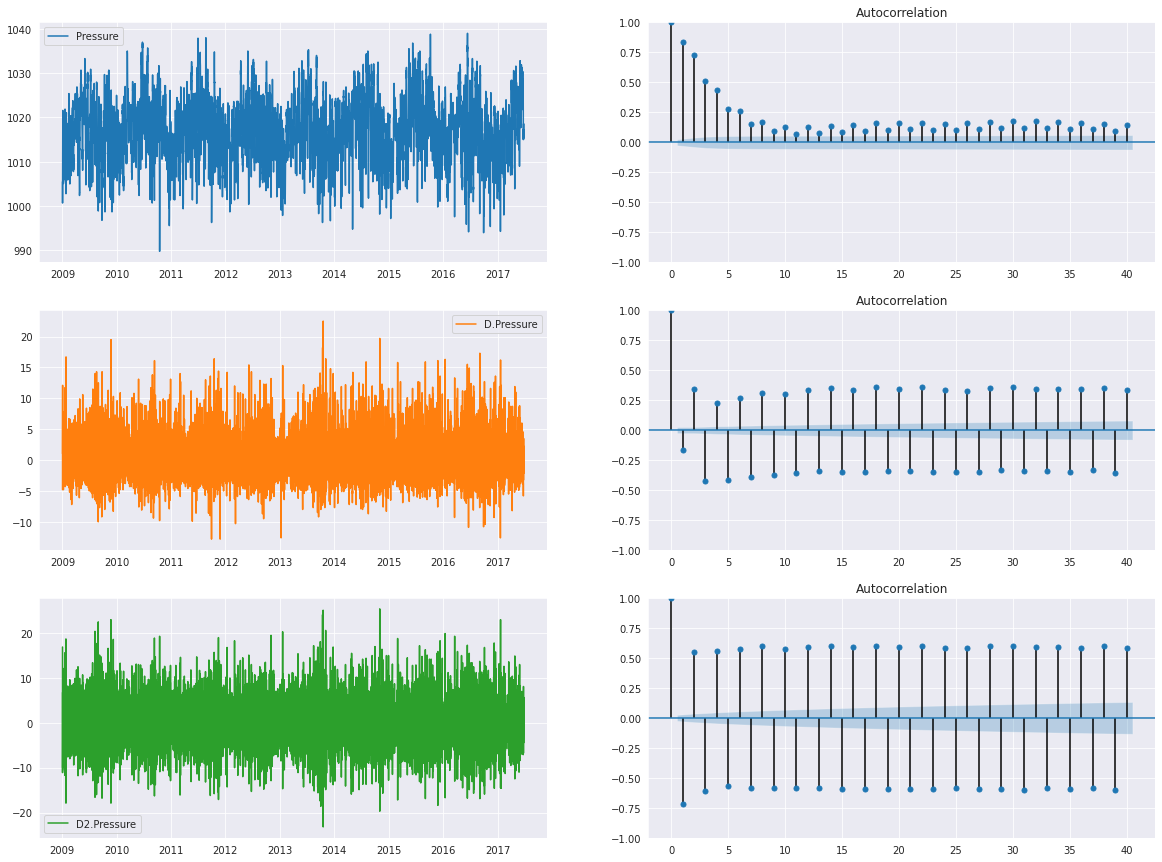

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=[20,15])

data.plot(kind='line',subplots=True, figsize=(15,10), ax=axes[:,0])

sm.graphics.tsa.plot_acf(data['Pressure'], ax=axes[0,1], lags=40)
sm.graphics.tsa.plot_acf(data['D.Pressure'].dropna(), ax=axes[1,1], lags=40)
sm.graphics.tsa.plot_acf(data['D2.Pressure'].dropna(), ax=axes[2,1], lags=40)

plt.show()

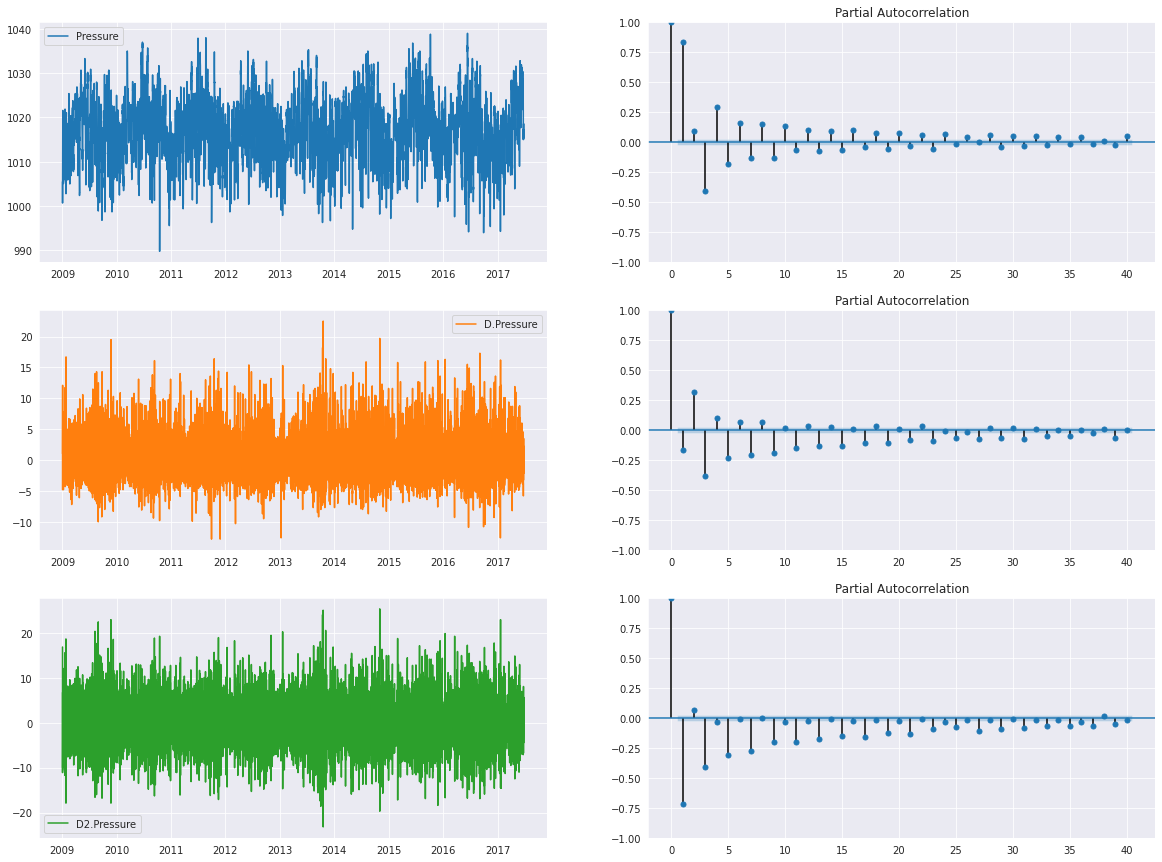

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=[20,15])

data.plot(kind='line',subplots=True, figsize=(15,10), ax=axes[:,0])

sm.graphics.tsa.plot_pacf(data['Pressure'], ax=axes[0,1], lags=40, method='ywm')
sm.graphics.tsa.plot_pacf(data['D.Pressure'].dropna(), ax=axes[1,1], lags=40, method='ywm')
sm.graphics.tsa.plot_pacf(data['D2.Pressure'].dropna(), ax=axes[2,1], lags=40, method='ywm')

plt.show()

In [ ]:
pressure_model = sm.tsa.arima.ARIMA(data['Pressure'].values, order=(1,3,3)) 
pressure_results = pressure_model.fit() 
print(pressure_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6196
Model:                 ARIMA(1, 3, 3)   Log Likelihood              -16126.727
Date:                Sat, 11 Jun 2022   AIC                          32263.453
Time:                        14:00:41   BIC                          32297.109
Sample:                             0   HQIC                         32275.122
                               - 6196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      0.000  -8997.192      0.000      -1.000      -1.000
ma.L1         -1.0087      0.004   -252.017      0.000      -1.017      -1.001
ma.L2         -0.9817      0.004   -252.615      0.0

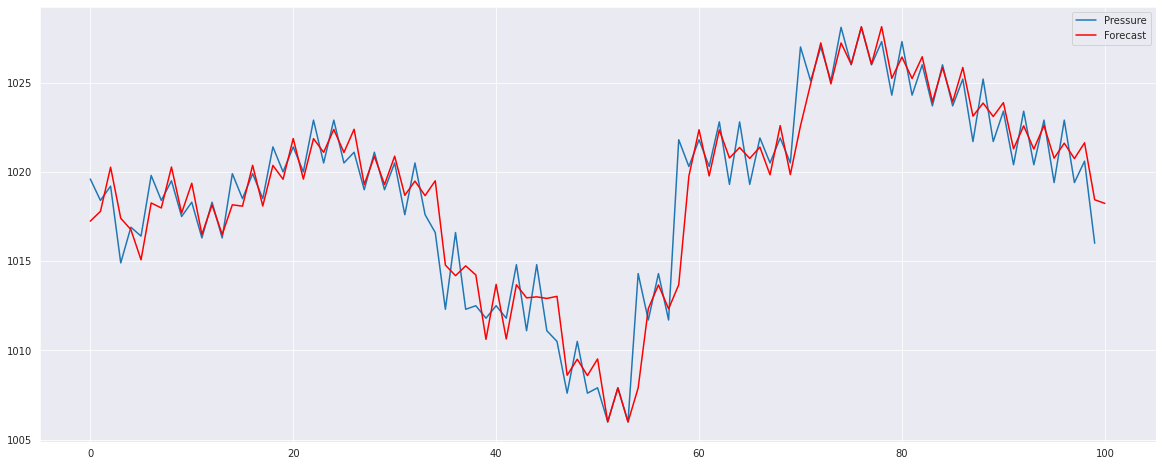

In [ ]:

fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(data['Pressure'].values[900:1000])
plt.plot(pressure_results.predict(start=900, end=1000), color='red')
ax.legend(['Pressure', 'Forecast'])

A differenza di ciò che abbiamo ottenuto con le piogge, nel caso della pressione possiamo prevedere il cambio di tendenza con una certa accuratezza, ossia, quando la curva della pressione passa da una pendenza negativa ad una positiva.

## Logistic Regression

Splitto i dati del Dataframe in training set e test set

In [ ]:
train, test = train_test_split(full_df, test_size=0.05)
df_dummy = pd.get_dummies(train, columns=['RainTomorrow'], drop_first=True)

In [ ]:
# Converto la variabile categorica RainToday in variabile numerica (Yes-No --> 1-0)
le = LabelEncoder()
train['RainToday'] = le.fit_transform(train['RainToday'])

# Prendo le variabili numeriche
X = train[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm','RainToday']]

# Variabile Target
Y = df_dummy['RainTomorrow_Yes']

# Fitting del modello
log_reg = sm.Logit(list(Y), X, missing="drop").fit(method='bfgs')
log_reg.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.378568
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               135382
Model:                          Logit   Df Residuals:                   135365
Method:                           MLE   Df Model:                           16
Date:                Sat, 11 Jun 2022   Pseudo R-squ.:                  0.2942
Time:                        14:01:50   Log-Likelihood:                -51251.
converged:                      False   LL-Null:                       -72618.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MinTemp          -0.0032      0.004     -0.804      0.421      -0.011       0.005
MaxTemp          -0.0012      0.006     -0.209      0.834      -0.012       0.010
Rainfall          0.0096      0.001      8.727      0.000       0.007       0.012
Evaporation      -0.0014      0.002     -0.697      0.486      -0.005       0.003
Sunshine         -0.0840      0.002    -35.003      0.000      -0.089      -0.079
WindGustSpeed     0.0543      0.001     67.154      0.000       0.053       0.056
WindSpeed9am     -0.0079      0.001     -6.670      0.000      -0.010      -0.006
WindSpeed3pm     -0.0199      0.001    -16.513      0.000      -0.022      -0.018
Humidity9am       0.0044      0.001      5.132      0.000       0.003       0.006
Humidity3pm       0.0525      0.001     58.471      0.000       0.051       0.054
Pressure9am       0.1343      0.004     30.167      0.000       0.126       0.143
Pressure3pm      -0.1415      0.004    -31.785      0.000      -0.150      -0.133
Cloud9am          0.0162      0.003      4.888      0.000       0.010       0.023
Cloud3pm          0.0923      0.004     26.377      0.000       0.085       0.099
Temp9am           0.0277      0.006      4.722      0.000       0.016       0.039
Temp3pm           0.0052      0.006      0.812      0.417      -0.007       0.018
RainToday         0.6109      0.021     28.884      0.000       0.569       0.652
=================================================================================
"""

Predizione

In [ ]:
#Predizione
Xtest = test[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm','RainToday']]
Xtest['RainToday'] = le.fit_transform(Xtest['RainToday'])       

ytest = test['RainTomorrow']

yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))
 
print("Il test è stato valutato su "+str(len(list(ytest.values)))+" dati metereologici (10% del dataset)")

Il test è stato valutato su 7126 dati metereologici (10% del dataset)


Valutazione

Comparo i valori originali con quelli predetti

In [ ]:
true_values = [None] * len(list(ytest.values))

# Mappo le sentenze Yes-No in 1-0 
for i in range(len(list(ytest.values))):
    if list(ytest.values)[i] == 'Yes':
        true_values[i] = 1
    else:
        true_values[i] = 0

# Calcolo la percentuale di precisione delle previsioni
total = len(true_values)
true_predict = 0
for i in range(len(true_values)):
    if true_values[i] == prediction[i]:
        true_predict += 1

print("Valori veri: "+str(true_values))
print("Valori predetti: "+str(prediction))
print( "La precision del modello è del "+str((true_predict*100)/len(true_values)) +"%")

Valori veri: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

## Recurrent Neural Network (LSTM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from numpy import concatenate

In [ ]:
'''
Pongo i dati come un problema di apprendimento supervisionato.
In particolare, la predizione delle variabili in uscita sarà data 
dalle misure degli ingressi al tempo attuale (t) e tutte le misure
in uscita al tempo precedente (t-1)
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  
   #Numero di features del dataset (t-n, ..., t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  
  #Sequenza in forecast (t, t+1, .... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  
  #Metto tutto insieme
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  
  #Droppo le righe con valori NaN, se ce sono
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [ ]:
nn_df = full_df[['MinTemp', 'MaxTemp', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']]

In [ ]:
train, test = train_test_split(nn_df, test_size=0.1)

In [ ]:
print(train.columns)
print(test.shape)

Index(['MinTemp', 'MaxTemp', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm'],
      dtype='object')
(14251, 6)


Data Normalization

In [ ]:
train_scaler = StandardScaler().fit(train)
test_scaler = StandardScaler().fit(test)

train = train_scaler.transform(train)
test = test_scaler.transform(test)
train[0:1,]

array([[ 0.00339293, -0.99058183,  2.08812286,  2.21754998, -0.49332055,
        -0.92598244]])

Reframing

In [ ]:
#Faccio il 'reframe' dei dati
reframed_train = series_to_supervised(train, 1, 1)
reframed_test = series_to_supervised(test,1,1)

In [ ]:
reframed_train.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [ ]:
print(reframed_train.head(2))
print(reframed_test.head(2))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.003393  -0.990582   2.088123   2.217550  -0.493321  -0.925982  0.035060   
2   0.035060  -0.531805  -0.485452  -0.739326  -0.399201  -0.545397 -0.756614   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1 -0.531805 -0.485452 -0.739326 -0.399201 -0.545397  
2 -1.248644  1.159948  1.531898 -1.230592 -1.189465  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1  -0.103024  -0.629666  -0.049999   0.019927  -0.049248  -0.619060 -0.968467   
2  -0.968467   0.157975  -0.204152  -0.435144   0.076005  -0.062796 -1.786704   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.157975 -0.204152 -0.435144  0.076005 -0.062796  
2 -0.944723  0.804849  0.674092 -1.270464 -0.794722  


Split input e output

In [ ]:
train = reframed_train.values
test = reframed_test.values

# Splitto i valori che andranno in input quelli che saranno come taget

# selezionare le ultime n colonne --> [:, -n:]
# escludere le ultime n colonne --> [:, :-n]
train_x, train_y = train[:, :-6], train[:,-6:]
test_x, test_y = test[:, :-6], test[:, -6:]

#Faccio il rashape in 3d come lo vuole lstm (sample, timesteps, features)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(128256, 1, 6) (128256, 6) (14250, 1, 6) (14250, 6)


Fitting

Epoch 1/50
2004/2004 - 5s - loss: 0.8074 - val_loss: 0.8083 - 5s/epoch - 3ms/step
Epoch 2/50
2004/2004 - 3s - loss: 0.8066 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 3/50
2004/2004 - 3s - loss: 0.8066 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 4/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 5/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 6/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 7/50
2004/2004 - 4s - loss: 0.8065 - val_loss: 0.8081 - 4s/epoch - 2ms/step
Epoch 8/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 9/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 10/50
2004/2004 - 4s - loss: 0.8065 - val_loss: 0.8081 - 4s/epoch - 2ms/step
Epoch 11/50
2004/2004 - 3s - loss: 0.8065 - val_loss: 0.8081 - 3s/epoch - 2ms/step
Epoch 12/50
2004/2004 - 4s - loss: 0.8065 - val_loss: 0.8081 - 4s/epoch - 2ms/step
Epoch 13/50
2

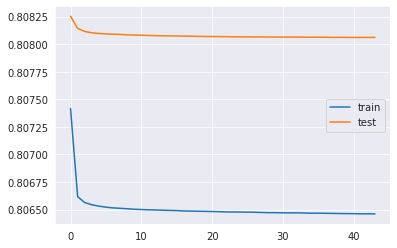

In [ ]:
#Modellazine della rete
model = Sequential()
model.add(LSTM(6, input_shape=(train_x.shape[1], train_x.shape[2])))

model.compile(loss='mae', optimizer='adam')


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#Fit della rete
'''
Parametri di fit
train_x --> dati in input
train_y --> dati target
'''
history = model.fit(train_x, train_y, epochs=50, batch_size=64, validation_data=(test_x, test_y), verbose=2, shuffle=False,callbacks=[callback,callback2])

#Plot dei risultati
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Predizione

In [ ]:
#Predizione/forecast
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))

print(yhat.shape)

(14250, 6)


In [ ]:
#Scaling inverso per il forecast
yhat = test_scaler.inverse_transform(yhat)

print(yhat)
print(yhat.shape)

[[  12.018373    22.57249   1017.78      1015.30164     16.68497
    21.134169 ]
 [  11.841291    22.599916  1017.8237    1015.3126      16.726795
    21.156282 ]
 [  12.010357    22.658922  1017.81287   1015.3995      16.79317
    21.18046  ]
 ...
 [  12.0883665   22.537455  1017.7876    1015.55164     16.733192
    21.07054  ]
 [  12.108191    22.510342  1017.78564   1015.3966      16.699842
    21.038523 ]
 [  12.104796    22.505434  1017.78723   1015.4305      16.729563
    21.034721 ]]
(14250, 6)


In [ ]:
#Scaling inverso per i valori veri
test_y = test_y.reshape((len(test_y), 6))
test_y = test_scaler.inverse_transform(test_y)

print(test_y.shape)

(14250, 6)


Valutazione

In [ ]:
#Calcolo la RMSE
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.801


Rosso: valori predetti


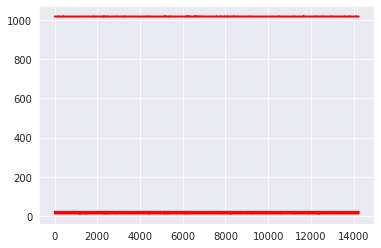


Blu: valori reali


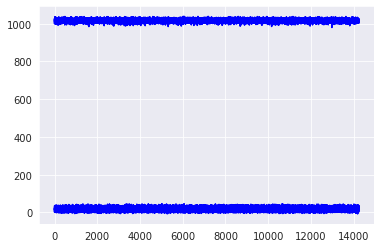

In [ ]:
print("Rosso: valori predetti")
pyplot.plot(yhat, color='red')
pyplot.show()

print()

print("Blu: valori reali")
pyplot.plot(test_y, color='blue')
pyplot.show()

##RNN

In [ ]:
# TODO: serve usare solo una località alla volta?
# TODO: pendere qualche parole sulle reti neurali ricorrenti
# BUG: non predice niente non so perchè. Che cambia tra i due dataset?

In [ ]:
# Salvo il contenuto del dataset in un Dataframe
df = full_df.sort_values(by=['Location','Date']).drop(columns = ['Date','Location','WindGustDir', 'WindDir9am', 'WindDir3pm','RainToday','RainTomorrow','Temp_diff','WindPressure_diff','Cloud_diff','Humidity_diff'])

In [ ]:
df = num_df
df

,Temp3pm,Temp9am,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,Humidity3pm,Humidity9am,WindSpeed3pm,WindSpeed9am,WindGustSpeed,Sunshine,Evaporation,Rainfall,MaxTemp,MinTemp
2009-01-01,34.3,22.0,6.0,4.0,1000.7,1005.5,22.0,73.0,17.0,11.0,56.0,12.9,9.8,0.0,34.7,18.4
2009-01-02,20.8,20.1,7.0,6.0,1013.8,1012.8,57.0,62.0,33.0,11.0,41.0,5.9,11.0,0.0,22.7,18.8
2009-01-03,21.4,18.8,8.0,8.0,1019.4,1021.6,49.0,58.0,15.0,13.0,26.0,0.5,9.0,0.0,23.0,17.0
2009-01-04,24.1,23.0,1.0,2.0,1015.2,1018.6,58.0,59.0,31.0,13.0,37.0,11.3,5.4,0.0,24.6,18.7
2009-01-05,26.2,23.4,4.0,4.0,1008.9,1013.2,60.0,66.0,13.0,6.0,41.0,12.2,10.0,0.0,27.9,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-21,17.9,10.5,2.0,2.0,1025.3,1025.9,52.0,73.0,20.0,22.0,37.0,7.8,2.0,0.0,19.6,8.6
2017-06-22,18.7,11.0,2.0,2.0,1024.6,1028.5,53.0,78.0,7.0,20.0,30.0,9.2,2.0,0.0,19.2,9.3
2017-06-23,17.3,10.2,6.0,6.0,1015.0,1020.8,56.0,85.0,13.0,15.0,24.0,2.7,2.4,0.0,17.7,9.4
2017-06-24,19.0,12.4,2.0,5.0,1015.1,1017.3,35.0,56.0,19.0,17.0,43.0,9.3,1.4,0.0,19.3,10.1


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='Temp9am', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Fitting (... circa 20 minuti con 30 epoche)

In [ ]:
%%time

MAX_EPOCHS = 30
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

val_performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

performance = {}
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

19/19 [==============================] - 0s 7ms/step - loss: 125544.0000 - mean_absolute_error: 136.1642

CPU times: user 55.9 s, sys: 4.43 s, total: 1min
Wall time: 51.4 s


Performance

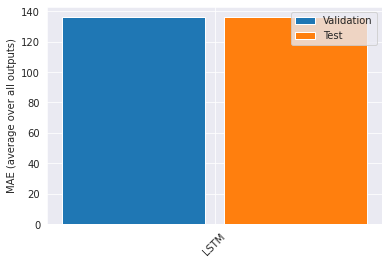

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

LSTM           : 135.8424


Risultati

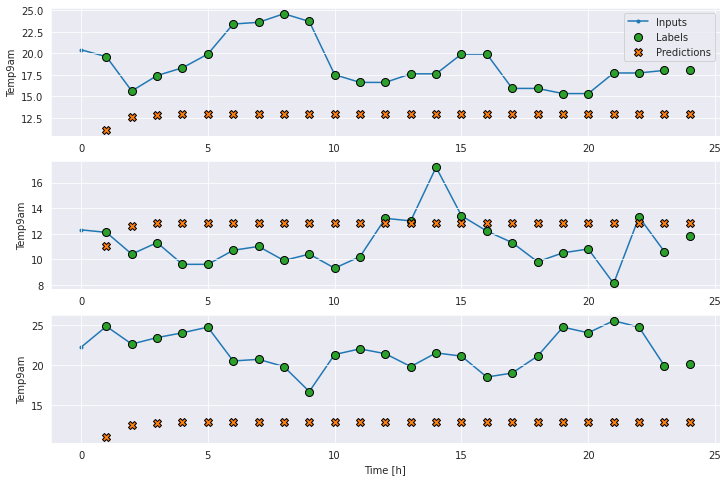

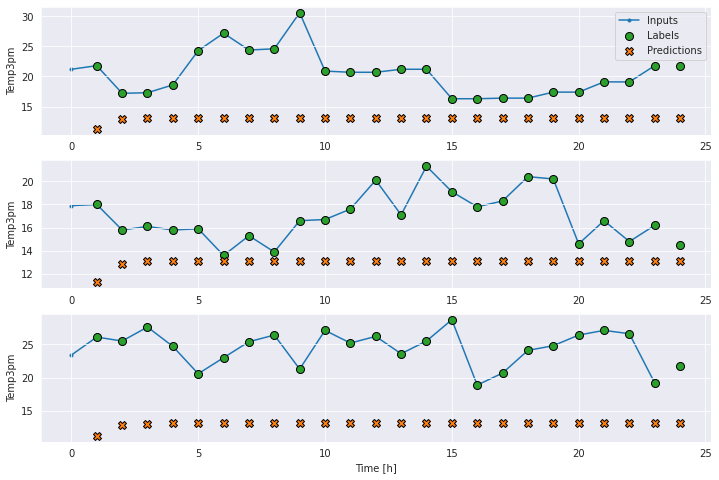

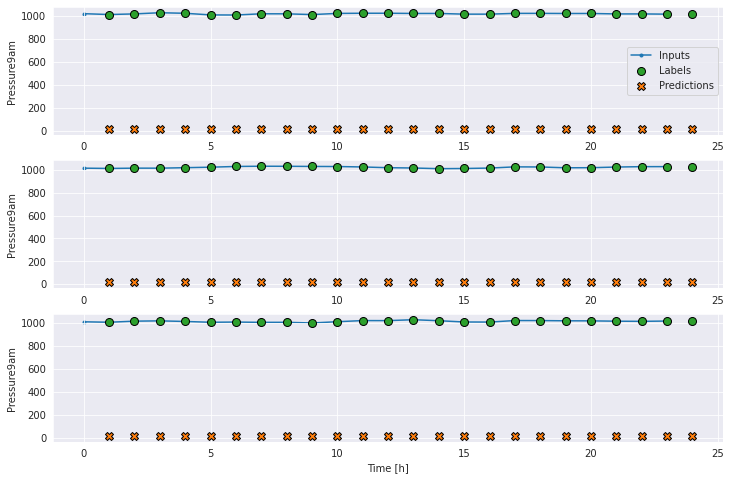

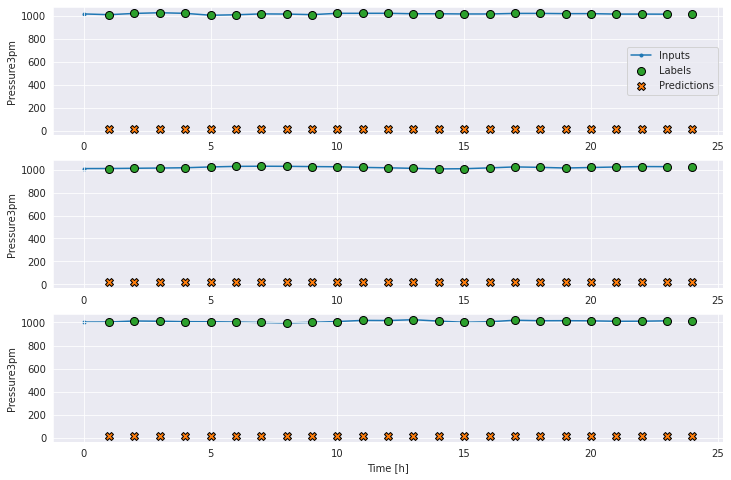

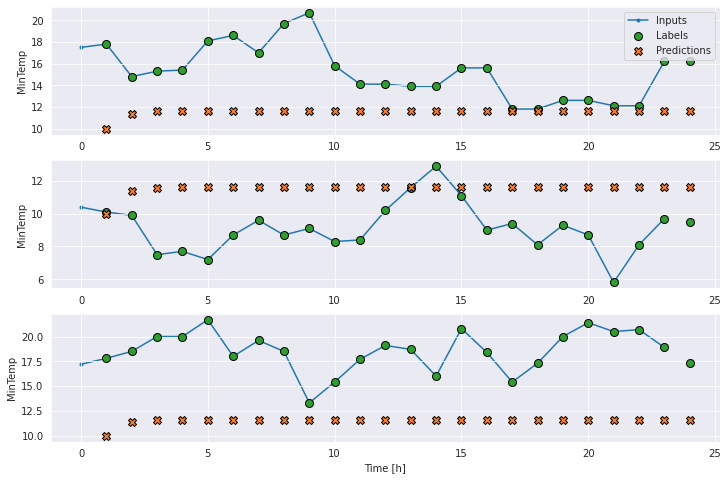

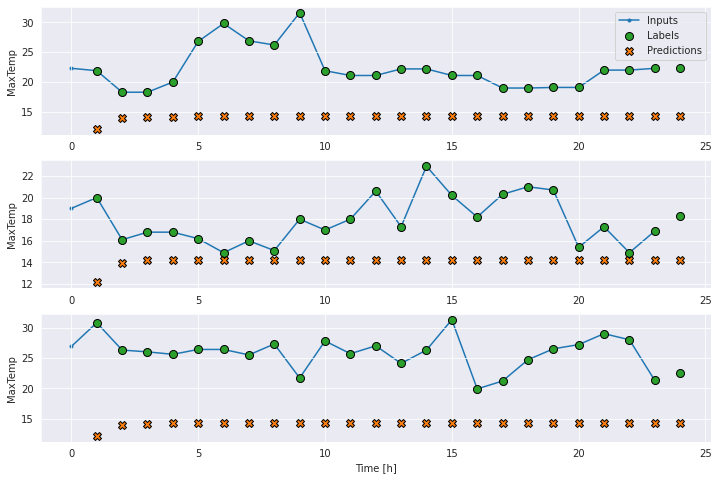

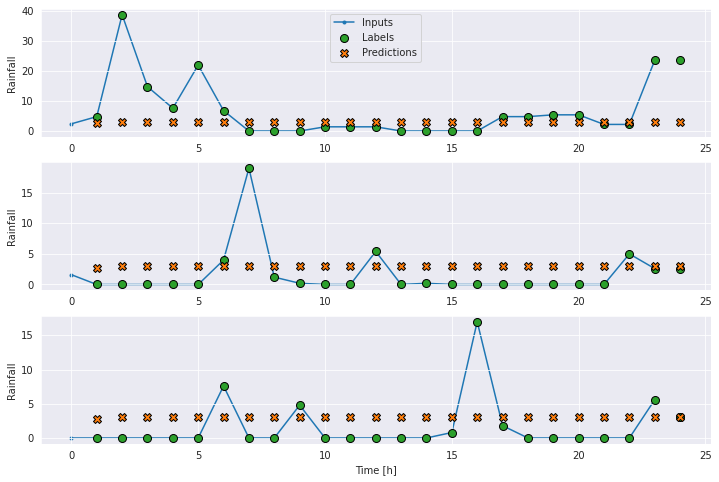

In [ ]:
wide_window.plot(lstm_model,plot_col='Temp9am')
wide_window.plot(lstm_model,plot_col='Temp3pm')
wide_window.plot(lstm_model,plot_col='Pressure9am')
wide_window.plot(lstm_model,plot_col='Pressure3pm')
wide_window.plot(lstm_model,plot_col='MinTemp')
wide_window.plot(lstm_model,plot_col='MaxTemp')
wide_window.plot(lstm_model,plot_col='Rainfall')

In [ ]:
#TODO provo a seguire il tutorial in https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

## Classificatore

In [ ]:
dataframe = num_df
dataframe["target"] =np.where(full_df[full_df['Location'] == 'Sydney']['RainTomorrow'] == 'No', 0, 1) 

In [ ]:
dataframe

,Temp3pm,Temp9am,Cloud3pm,Cloud9am,Pressure3pm,Pressure9am,Humidity3pm,Humidity9am,WindSpeed3pm,WindSpeed9am,WindGustSpeed,Sunshine,Evaporation,Rainfall,MaxTemp,MinTemp,target
2009-01-01,34.3,22.0,6.0,4.0,1000.7,1005.5,22.0,73.0,17.0,11.0,56.0,12.9,9.8,0.0,34.7,18.4,0
2009-01-02,20.8,20.1,7.0,6.0,1013.8,1012.8,57.0,62.0,33.0,11.0,41.0,5.9,11.0,0.0,22.7,18.8,0
2009-01-03,21.4,18.8,8.0,8.0,1019.4,1021.6,49.0,58.0,15.0,13.0,26.0,0.5,9.0,0.0,23.0,17.0,0
2009-01-04,24.1,23.0,1.0,2.0,1015.2,1018.6,58.0,59.0,31.0,13.0,37.0,11.3,5.4,0.0,24.6,18.7,0
2009-01-05,26.2,23.4,4.0,4.0,1008.9,1013.2,60.0,66.0,13.0,6.0,41.0,12.2,10.0,0.0,27.9,19.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-21,17.9,10.5,2.0,2.0,1025.3,1025.9,52.0,73.0,20.0,22.0,37.0,7.8,2.0,0.0,19.6,8.6,0
2017-06-22,18.7,11.0,2.0,2.0,1024.6,1028.5,53.0,78.0,7.0,20.0,30.0,9.2,2.0,0.0,19.2,9.3,0
2017-06-23,17.3,10.2,6.0,6.0,1015.0,1020.8,56.0,85.0,13.0,15.0,24.0,2.7,2.4,0.0,17.7,9.4,0
2017-06-24,19.0,12.4,2.0,5.0,1015.1,1017.3,35.0,56.0,19.0,17.0,43.0,9.3,1.4,0.0,19.3,10.1,0


In [ ]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [ ]:
print(len(train), 'esempi di addestramento')
print(len(val), 'esempi di validazione')
print(len(test), 'esempi di test')

2478 esempi di addestramento
310 esempi di validazione
310 esempi di test


Per convertire in `tf.Data.Dataset` e mischiare i dati.



In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of temperature:', train_features['Temp3pm'])
print('A batch of targets:', label_batch )

Every feature: ['Temp3pm', 'Temp9am', 'Cloud3pm', 'Cloud9am', 'Pressure3pm', 'Pressure9am', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am', 'WindGustSpeed', 'Sunshine', 'Evaporation', 'Rainfall', 'MaxTemp', 'MinTemp', 'target']
A batch of temperature: tf.Tensor(
[[22.3]
 [28.7]
 [19.3]
 [17.6]
 [20.9]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int64)


### Normalizzazione

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Temp3pm', 'Temp9am', 'Cloud3pm', 'Cloud9am', 'Pressure3pm', 'Pressure9am', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am', 'WindGustSpeed', 'Sunshine', 'Evaporation', 'Rainfall', 'MaxTemp', 'MinTemp']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

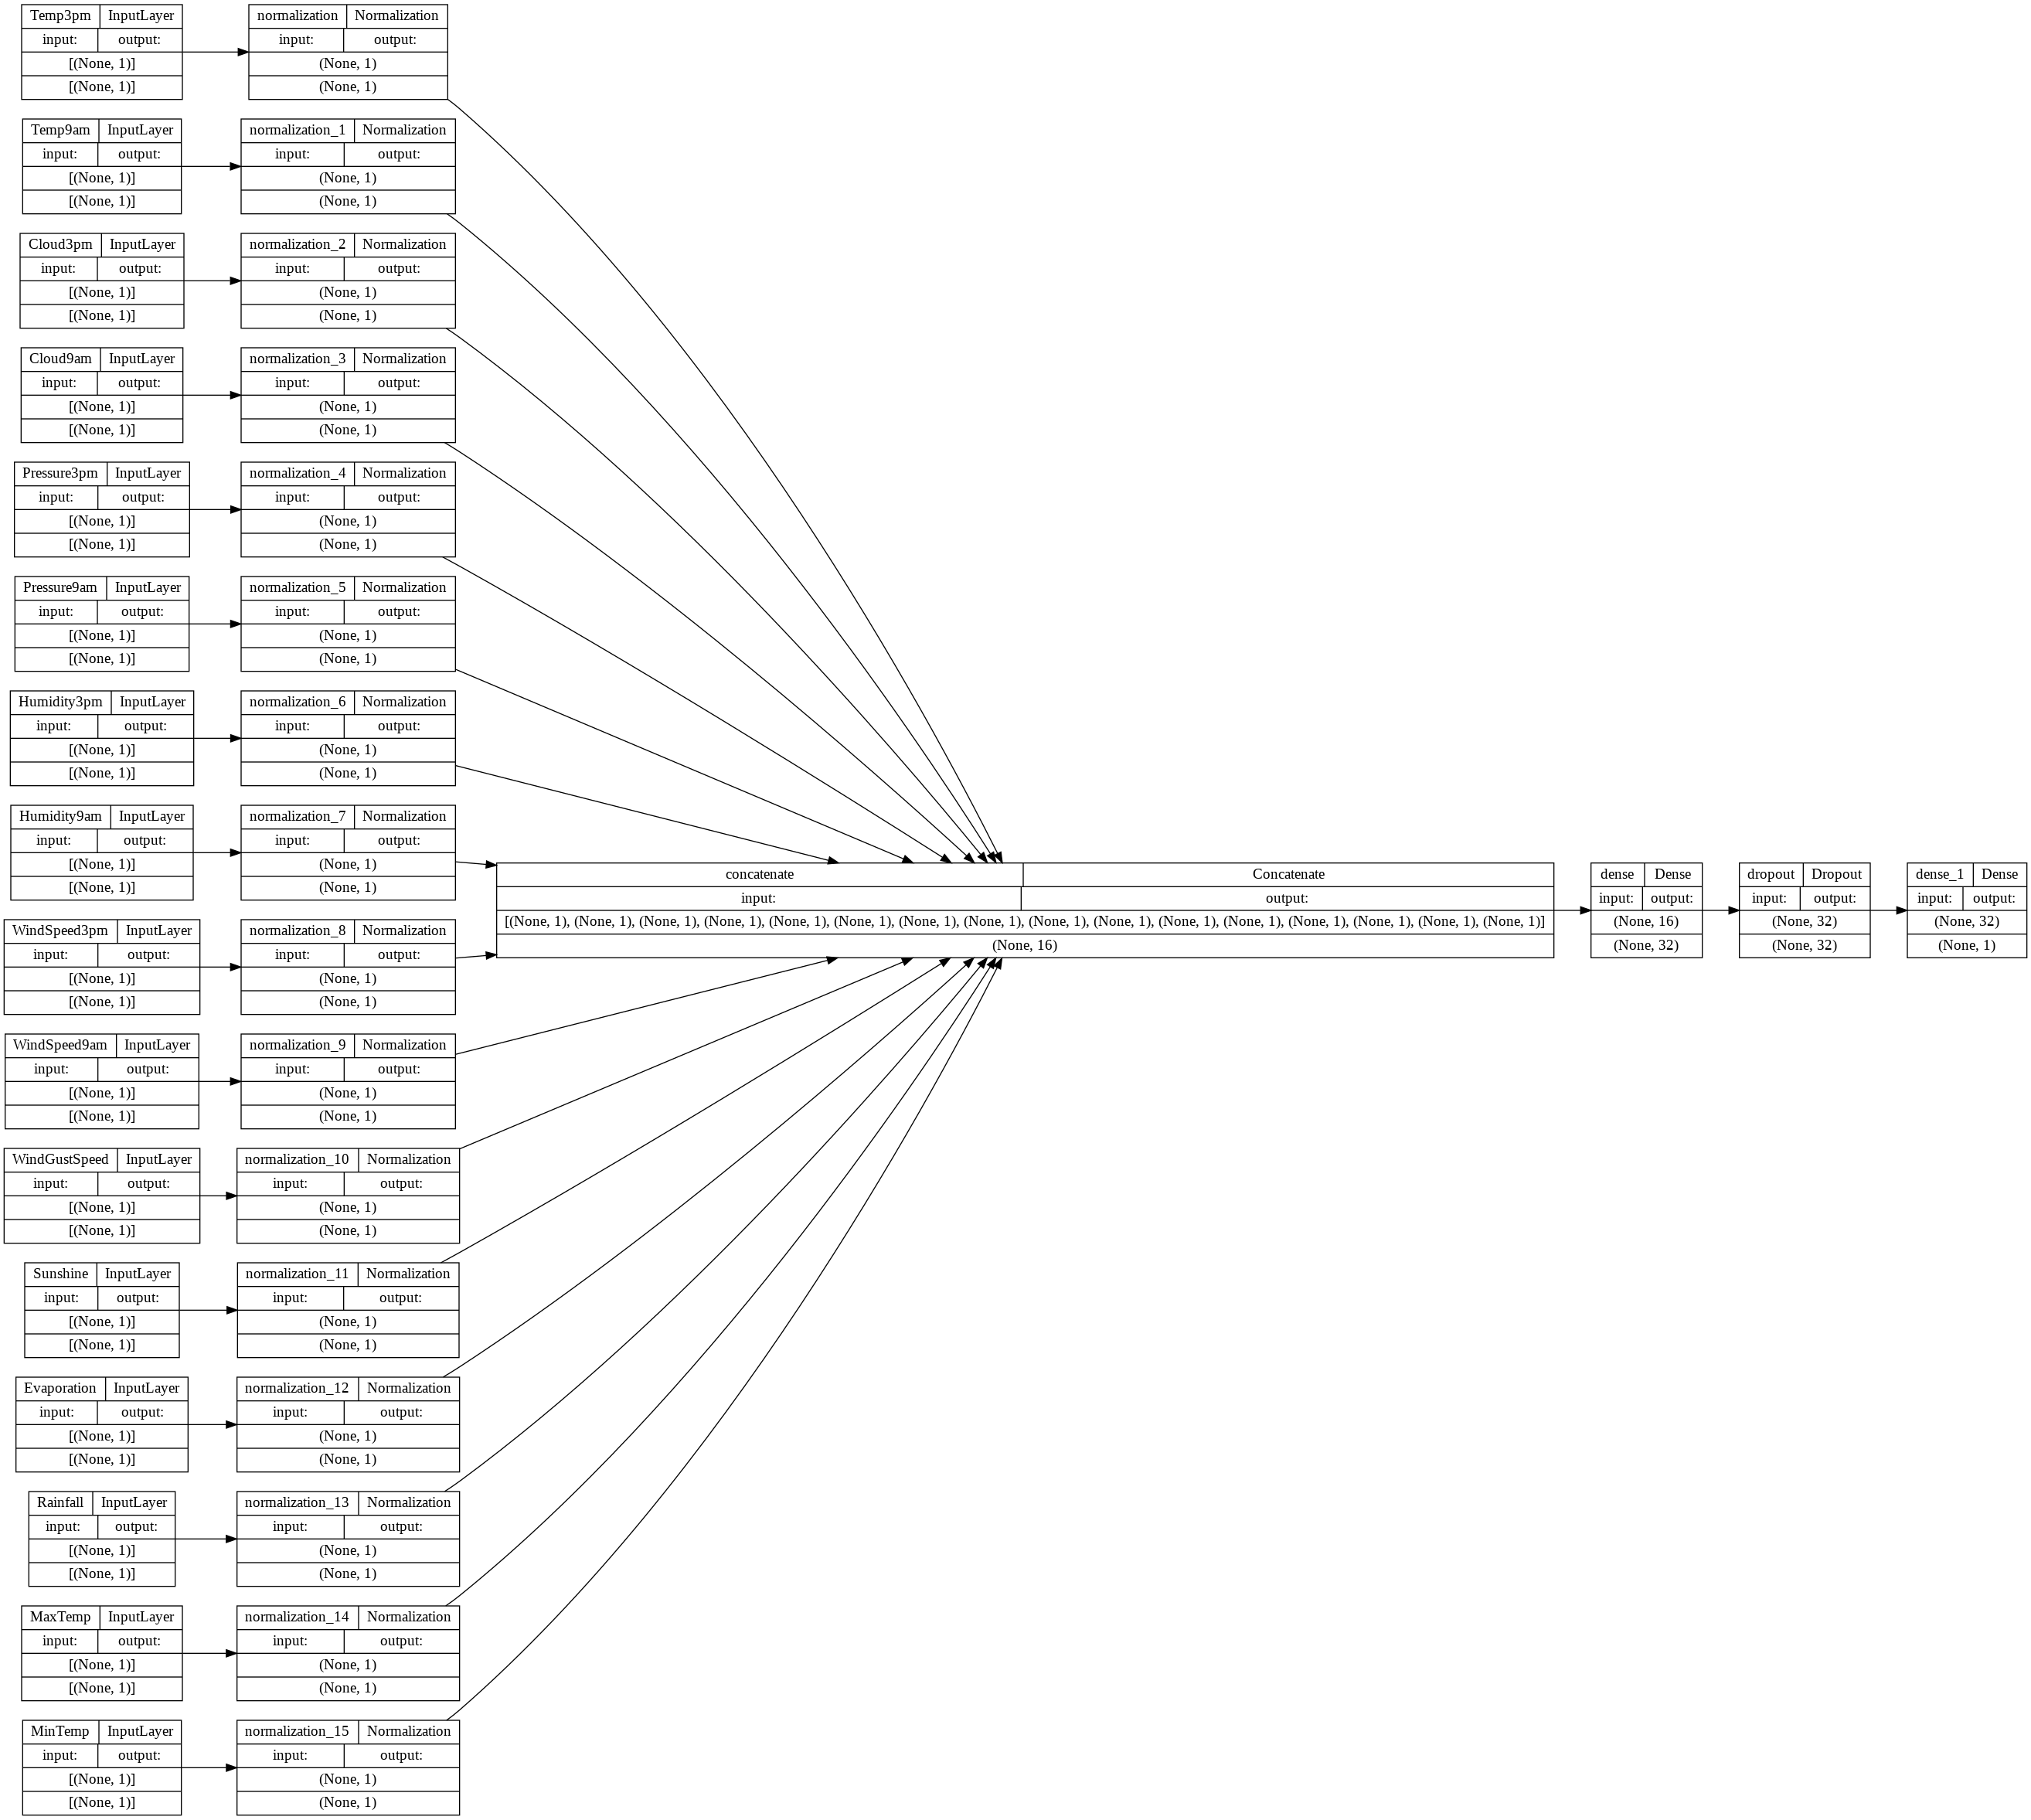

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/10 [==============================] - 2s 71ms/step - loss: 0.6987 - accuracy: 0.7203 - val_loss: 0.6148 - val_accuracy: 0.7419
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.6490 - accuracy: 0.7369 - val_loss: 0.5723 - val_accuracy: 0.7419
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.6177 - accuracy: 0.7373 - val_loss: 0.5385 - val_accuracy: 0.7419
Epoch 4/10
10/10 [==============================] - 0s 17ms/step - loss: 0.5727 - accuracy: 0.7506 - val_loss: 0.5126 - val_accuracy: 0.7419
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.5661 - accuracy: 0.7470 - val_loss: 0.4918 - val_accuracy: 0.7419
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.5384 - accuracy: 0.7542 - val_loss: 0.4749 - val_accuracy: 0.7419
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.5219 - accuracy: 0.7563 - val_loss: 0.4616 - val_accuracy: 0.7419
Epoch 8/10
10/10 [======

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 13ms/step - loss: 0.4856 - accuracy: 0.7161
Accuracy 0.7161290049552917


In [ ]:
model.save('rain_tomorrow_classifier')
reloaded_model = tf.keras.models.load_model('rain_tomorrow_classifier')

INFO:tensorflow:Assets written to: rain_tomorrow_classifier/assets


INFO:tensorflow:Assets written to: rain_tomorrow_classifier/assets


In [ ]:
# TODO testare il modello e graficare qualcosa
test_sample = df_to_dataset(test, shuffle=False, batch_size=1)

for sample in test_sample:
    #print(sample[0])
    predictions = reloaded_model.predict(sample[0])
    prob = tf.nn.sigmoid(predictions[0]) # con la sigmoid ho la probabilità 
    print("Probabilità del %.1f percento che piova il giorno dopo." % (100 * prob))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


Probabilità del 45.9 percento che piova il giorno dopo.
Probabilità del 28.8 percento che piova il giorno dopo.
Probabilità del 60.4 percento che piova il giorno dopo.
Probabilità del 14.7 percento che piova il giorno dopo.
Probabilità del 4.6 percento che piova il giorno dopo.
Probabilità del 21.8 percento che piova il giorno dopo.
Probabilità del 82.2 percento che piova il giorno dopo.
Probabilità del 69.2 percento che piova il giorno dopo.
Probabilità del 40.6 percento che piova il giorno dopo.
Probabilità del 34.6 percento che piova il giorno dopo.
Probabilità del 6.0 percento che piova il giorno dopo.
Probabilità del 28.2 percento che piova il giorno dopo.
Probabilità del 30.7 percento che piova il giorno dopo.
Probabilità del 35.3 percento che piova il giorno dopo.
Probabilità del 49.3 percento che piova il giorno dopo.
Probabilità del 21.5 percento che piova il giorno dopo.
Probabilità del 47.5 percento che piova il giorno dopo.
Probabilità del 26.3 percento che piova il giorno 